# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [19]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, cls, uf, config):
    '''Randomly sample a color for each cluster'''
    max_col = None
    for cluster in uf.components():
        for site_str in cluster:
            site = str2site(site_str)
            max_col = cluster_constraints[cls[site[0],site[1]]]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            break
        for site_str in cluster:
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    if prt: print("done sampling cluster colors")
    
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.uint16) # up to 255x255 box
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
            cluster_constraints[cl_n] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for cluster in uf.components():
            cluster_color = color_arr[i]
            for site_str in cluster:
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        '''Randomly sample a color for each cluster'''
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
        config = brute_force_sample (cluster_constraints, cls, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [20]:
def single_experiment (N, no_cols, gamma=0, J=0, alpha=0, iters=100):
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    param_name = "Alpha"

    '''Probabilities ordered from highest (high energy) to lowest'''
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)

    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)

    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)

    eta_prob = (lambda_prob, edge_prob, site_prob)

    '''Current states of eta'''
    eta_lambda = 0
    eta_edges = np.zeros((N,N,2), dtype=np.int8)
    # Special edge cases (no neighbors at the border)
    eta_edges[:,N-1,1] = -1
    eta_edges[N-1,:,0] = -1
    eta_sites = np.zeros((N,N), dtype=np.int8)
    eta = [eta_lambda, eta_edges, eta_sites]

    '''List of sites (tuples) for Union-Find'''
    sites = []
    for i in range(N):
        for j in range(N):
            sites.append(str(i)+','+str(j))

    config = initial_config(N, no_cols)
    print('\ninitial config:')
    print(config)
    for i in range(iters):
        print('\n' + '-'*50 + ' iter ' + str(i) + ' ' + '-'*50)
        config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)

    print('\nfinal config:')
    print(config)
    plt.imshow(config)
    plt.show()

    session.terminate()

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
edge probabilities: [0.32967995 0.67032005]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 1  1  6  6  8]
 [ 9  5  2 10  5]
 [ 7  1  7  6  1]
 [ 7 10  8  2 10]
 [ 5  9  8  6  4]]

-------------------------------------------------- iter 0 --------------------------------------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
current no. cols (lambda): 9
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  

probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  0  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 0  1  1  1 -1]
 [ 1  1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [12 12 16 17 18]
 [19 20 21 22 23]]
Case with no field and gamma > 0
prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000, 44707065704248590720000, 34812534627691083648000]
prob_k: [1.00000000e-22 3.77487270e-15 1.12941616e-10 1.46983666e-07
 2.91564670e-05 1.51044243e-03 2.65062188e-02 1.76758032e-01
 4.47070657e-01 3.48125346e-01]
exact number of colors to

probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 0  1  1  1  1]
 [ 0  1  1  1  1]
 [ 1  1  1  1  1]
 [ 0  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  0  1  1 -1]
 [ 0  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  2  3  4]
 [ 1  1  5  6  7]
 [ 1  8  9 10 11]
 [12 13 14 15 16]
 [12 17 18 19 20]]
Case with no field and gamma > 0
prob_k: [10, 47185830, 418036641120, 227969864141040, 22655992176720000, 651079128982060800, 6739621486810329600]
prob_k: [1.34887507e-18 6.36477899e-12 5.63879205e-08 3.07502867e-05
 3.05601031e-03 8.78224407e-02 9.09090742e-01]
exact number of colors to use in configuration:
7
Bell found (20, 7)
partition_dict {(6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 38760, (5, 1, 0, 0, 0, 0, 0, 0

[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  2  7  4  8]
 [ 9 10 11 12 13]
 [14 14 15 16 17]
 [18 19 20 21 22]]
Case with no field and gamma > 0
prob_k: [10, 188743590, 3764217204000, 3668004264078000, 578727734620543200, 24691767308998020000, 364550687404307712000, 2072768890736795328000]
prob_k: [4.06075912e-21 7.66442254e-14 1.52855793e-09 1.48948818e-06
 2.35007392e-04 1.00267319e-02 1.48035253e-01 8.41701517e-01]
exact number of colors to use in configuration:
7
Bell found (22, 7)
partition_dict {(6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 74613, (5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 3581424, (5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 17907120, (5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 62674920, (5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 162954792, (5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 325909584, (5, 0, 0, 0, 0, 0, 1, 0, 0, 

partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 735471, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 47070144, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 235350720, (7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 823727520, (7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 2141691552, (7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 4283383104, (7, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 6731030592, (7, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 8413788240, (6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 1235591280, (6, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 11532185280, (6, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 37479602160, (6, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 89951045184, (6, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 164910249504, (6, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0): 235586070720, (6, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 132517164780, (6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 249

 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  7  8  4  9]
 [10 11 12 13 14]
 [15 16 17 18 18]
 [19 20 21 22 23]]
Case with no field and gamma > 0
prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000]
prob_k: [4.88271721e-22 1.84316359e-14 5.51461971e-10 7.17679675e-07
 1.42362783e-04 7.37506323e-03 1.29422371e-01 8.63059485e-01]
exact number of colors to use in configuration:
8
Bell found (23, 8)
partition_dict {(7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 245157, (6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 13728792, (6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 68643960, (6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 240253860, (6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 624660036, (6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1249320072, (6, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 1963217256, (6, 0, 0, 0, 0, 0, 0, 1, 1, 

probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]
Case with no field and gamma > 0
prob_k: [10, 1509949350, 101662553538000, 235727300283602400, 73685353617109110240, 5598394250400367416000, 137793085717623624288000, 1252341919597167951552000, 4238153361726180440544000, 4366039317526046160000000]
prob_k: [1.00000000e-24 1.50994935e-16 1.01662554e-11 2.35727300e-08
 7.36853536e-06 5.59839425e-04 1.37793086e-02 1.25234192e-01
 4.23815336e-01 4.36603932e-01]
exact number of colors to use in configuration:
9
Bell found (25, 9)
partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 1081575, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 73547100, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 392251200

Bell computed (23, 6)
partition_dict {(5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 33649, (4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 1514205, (4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 8580495, (4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 34321980, (4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 102965940, (4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 240253860, (4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 446185740, (4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 669278610, (4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 818007190, (3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 25741485, (3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 274575840, (3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1029659400, (3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 2883046320, (3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 6246600360, (3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 

exact number of colors to use in configuration:
9
Bell found (23, 9)
partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 490314, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 29418840, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 137287920, (7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 446185740, (7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1070845776, (7, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1963217256, (7, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 2804596080, (7, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0): 1577585295, (6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 720761580, (6, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 6246600360, (6, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 18739801080, (6, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 41227562376, (6, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 68712603960, (6, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 88344776520, (6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 12493200720, (6, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 

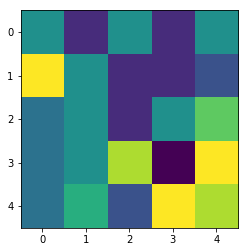

In [22]:
only_averages = False
prt = True
N, no_cols = 5, 10
gamma = 1    # strength of preference for low no. of cols
J = .2        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

## Full simulation

In [23]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [24]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_5.png", format="png")
    
#     plt.show()
    
    return params, avg_c, std_c

In [27]:
def plot_multiple (params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(N*N) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_" + save_opts + ".png", format="png")

    plt.show()

## J (edges / neighbor interaction) with multiple Gamma

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[13  6  2  7]
 [ 5 13  1 10]
 [ 8  9 12 16]
 [16 14  5 10]]
equilibration step: 0
1 num. cols: 10.0 avg. sites per col: 1.6
Final configuration:
[[ 1 10 14 11]
 [10  8  9 14]
 [15 13  2  4]
 [ 6  1  8 13]]
Final averages: 10.666666666666666 1.5277078477078474
Final stds: 1.398411797560202 0.21320199969888998
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[

1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[ 6 13 14  3]
 [16 11 16  9]
 [11  5  4  2]
 [ 5 11 16 11]]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[12 12 12 12]
 [12 12 12 12]
 [12 12 12 12]
 [12 12 12 12]]
Final averages: 1.6 11.2
Final stds: 0.48989794855663565 3.9191835884530852
------------------------------------------------------------------------------------------------------------------------

18  - param: 1.8
edge probabilities: [0.97267628 0.02732372]
Initial configuration
[[ 5 13  5 16]
 [ 6  4  6 15]
 [15  4 10 15]
 [ 4 14 16  7]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configur

1 num. cols: 6.0 avg. sites per col: 2.6666666666666665
Final configuration:
[[ 1 15  2 16]
 [ 1  6  1  1]
 [ 6  6  6  1]
 [ 5 14  6  1]]
Final averages: 6.933333333333334 2.3238095238095235
Final stds: 0.573488351136175 0.19610724078070474
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[11  9 11  1]
 [10 13  5  2]
 [ 9 16 13 12]
 [ 6  4  9  7]]
equilibration step: 0
1 num. cols: 3.0 avg. sites per col: 5.333333333333333
Final configuration:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
Final averages: 2.2666666666666666 8.0
Final stds: 0.6798692684790381 3.3730961708462712
------------------------------------------------------------------------------------------------------------------------

10  - param: 1.0
edge probabilities: [0.86466472 0.13533528]
Initial configuration
[[11  6  1 16]
 [ 3  4 11 16]
 [16 12  9 10]
 [15  1  4  

1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
Final configuration:
[[13  4 13 16]
 [16 14 14  6]
 [ 6  5  9  2]
 [14  5  9  5]]
Final averages: 7.4 2.1714285714285713
Final stds: 0.48989794855663554 0.139970842444753
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[15  9 11 15]
 [15 13 14 14]
 [12  4  3  8]
 [ 3  7  8 15]]
equilibration step: 0
1 num. cols: 5.0 avg. sites per col: 3.2
Final configuration:
[[11  3 15 16]
 [11 14 14 12]
 [ 3 14 12 12]
 [12 12 15 11]]
Final averages: 5.733333333333333 2.8088888888888888
Final stds: 0.44221663871405337 0.23584887398082854
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
Initial configuration
[[ 3  7  2 11]
 [ 9  6  1 13]
 [ 2 11  4 12]
 [12 14  

------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[ 3 12  2  9]
 [11  1 15  2]
 [ 8 13  3  9]
 [12 12 11 14]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
Initial configuration
[[13  3  7  7]
 [ 2  7  4 13]
 [11  8 12 12]
 [ 9 10 14  5]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[10 10 10 10]
 [10 10 10 10]
 [10 10 10 10]
 [10 10 10 10]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
--------------------------------------------------------------------------------------

[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

12  - param: 1.2
edge probabilities: [0.90928205 0.09071795]
Initial configuration
[[ 1 11  2  4]
 [15  6  5  1]
 [10  8 11  9]
 [ 8 16 14 11]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[ 3  9  2  1]
 [12  9  7  9]
 [ 8 16 11 14]
 [10  8  6 14]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------

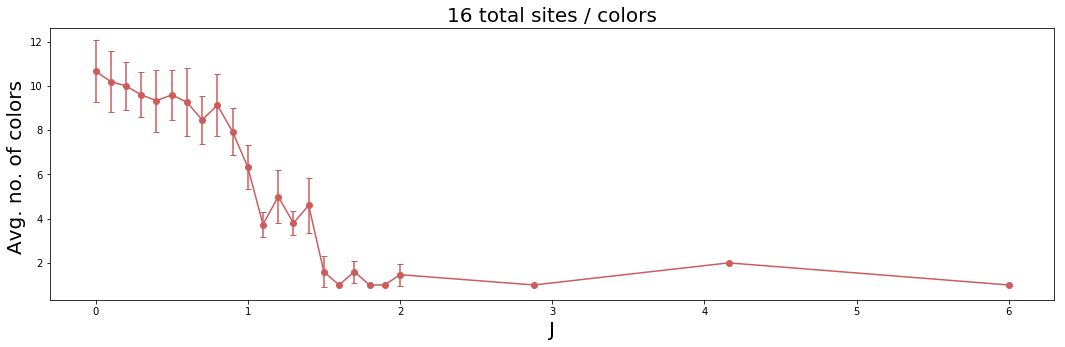

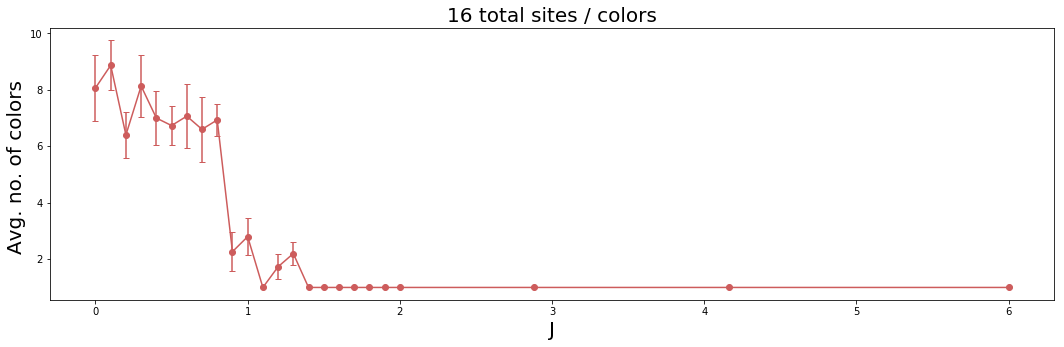

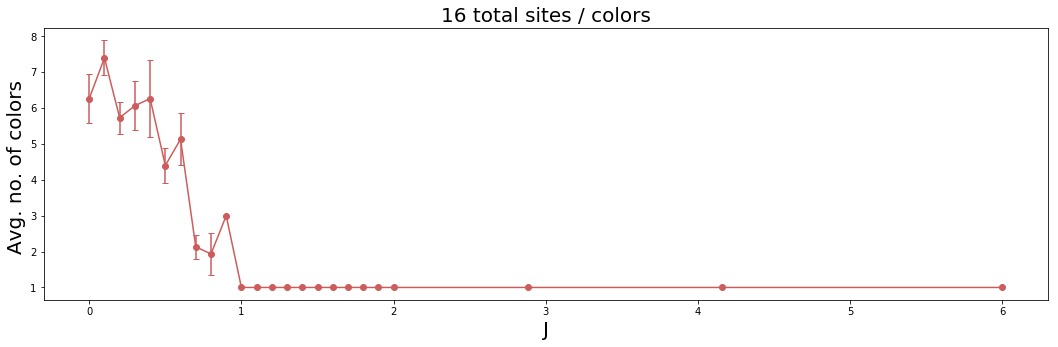

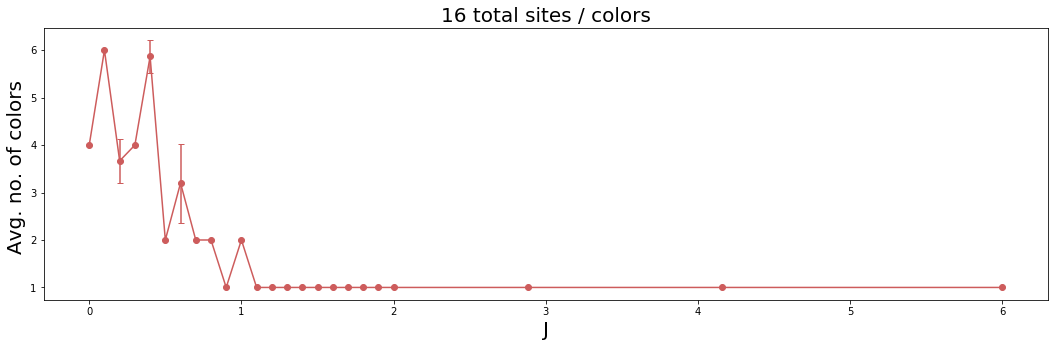

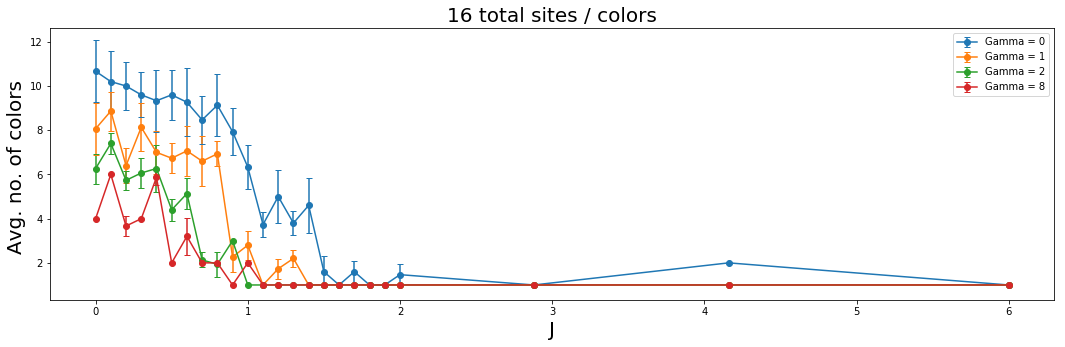

In [26]:
eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 4

k=0
ngamma = 4
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma", save_opts="5")

In [ ]:
# RESCALING J

eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 4

k=0
ngamma = 4
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma", save_opts="rescale_J")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[20  7 11 21  7]
 [ 4 12 21  7  1]
 [21 19 19  4  7]
 [13 24 23  5 14]
 [24  7  9 20 22]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 16.04950495049505 avg. sites per col: 1.571403644634187
201 num. cols: 16.074626865671643 avg. sites per col: 1.5697821072890397
301 num. cols: 15.9568

401 num. cols: 14.86783042394015 avg. sites per col: 1.7036991028555295
501 num. cols: 14.920159680638722 avg. sites per col: 1.697178335171701
601 num. cols: 14.910149750415973 avg. sites per col: 1.6987727143997289
701 num. cols: 14.954350927246791 avg. sites per col: 1.6934641112258912
801 num. cols: 14.945068664169789 avg. sites per col: 1.6950471508809504
901 num. cols: 14.93007769145394 avg. sites per col: 1.6970678972715774
1001 num. cols: 14.883116883116884 avg. sites per col: 1.7022733090720839
Final configuration:
[[12 25 10  5  9]
 [ 3 18  5 18 10]
 [21 12  2 13 17]
 [ 2 14 10 17 22]
 [23 11  9  7  4]]
Final averages: 14.891542288557213 1.7014182460528524
Final stds: 1.6990421970966938 0.20081633938509655
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[12  6 21  3  6]
 [ 7 24 19 24 14]
 [ 6 14 20  7  2]
 [ 3 21 18  1 21

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 5.287128712871287 avg. sites per col: 5.629723686654377
201 num. cols: 6.497512437810945 avg. sites per col: 4.506216213305763
301 num. cols: 5.840531561461794 avg. sites per col: 5.170778142123652
401 num. cols: 5.72568578553616 avg. sites per col: 5.126285116933499
501 num. cols: 6.429141716566866 avg. sites per col: 4.661036595916847
601 num. cols: 6.422628951747088 avg. sites per col: 4.687692599506248
701 num. cols: 6.1455064194008555 avg. sites per col: 4.968995084009352
801 num. cols: 6.390761548064919 avg. sites per col: 4.807876528382153
901 num. cols: 6.665926748057713 avg. sites per col: 4.606360697509428
1001 num. cols: 7.104895104895105 avg. sites per col: 4.381545028398171
Final configuration:
[[ 2 12 17 24 23]
 [ 2 19 20 25 23]
 [ 2 16 20 23 23]
 [16  3 23 23 23]
 [16 23 23 23 23

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.1293532338308458 avg. sites per col: 23.383084577114428
301 num. cols: 1.212624584717608 avg. sites per col: 22.3421926910299
401 num. cols: 1.2668329177057356 avg. sites per col: 21.706151288445557
501 num. cols: 1.4830339321357286 avg. sites per col: 20.088988689288144
601 num. cols: 1.4026622296173046 avg. sites per col: 20.906128674431546
701 num. cols: 1.3851640513552068 avg. sites per col: 20.99084640989067
801 num. cols: 1.3433208489388264 avg. sites per col: 21.4133374947982
901 num. cols: 1.3052164261931187 avg. sites per col: 21.81141324454313
1001 num. cols: 1.2747252747252746 avg. sites per col: 22.129953379953403
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.27363184

GAMMA: 1 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 3.77513454e-11]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[24  7  7  9  5]
 [21  3  2 19  8]
 [ 8 18  6  9 20]
 [22 14 10 16 19]
 [ 5  3  2  3  9]]
equilibration step: 0
equilibration step: 1000
equilibration step

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.089108910891088 avg. sites per col: 2.0940624282208455
201 num. cols: 11.950248756218905 avg. sites per col: 2.113573270289683
301 num. cols: 12.375415282392026 avg. sites per col: 2.0497356664788735
401 num. cols: 12.239401496259351 avg. sites per col: 2.0775042093987386
501 num. cols: 12.165668662674651 avg. sites per col: 2.0949856651248
601 num. cols: 12.299500831946755 avg. sites per col: 2.072164368153892
701 num. cols: 12.315263908701855 avg. sites per col: 2.067979289202115
801 num. cols: 12.319600499375781 avg. sites per col: 2.0681416043830576
901 num. cols: 12.233074361820199 avg. sites per col: 2.0828652090077187
1001 num. cols: 12.222777222777223 avg. sites per col: 2.085268266678758
Final configuration:
[[ 7  5 13 14 18]
 [17  5  5 20 21]
 [ 5 10  5 17  7]
 [ 7  1  9  9 18]
 [ 9  1 18 20 18]]
Final averages: 12.2248756218905

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 2.3267326732673266 avg. sites per col: 13.345709570957093
201 num. cols: 2.2487562189054726 avg. sites per col: 13.061774461028197
301 num. cols: 2.548172757475083 avg. sites per col: 11.940753045404229
401 num. cols: 2.5885286783042396 avg. sites per col: 11.54984562403515
501 num. cols: 2.3013972055888225 avg. sites per col: 13.876889078984886
601 num. cols: 2.3643926788685525 avg. sites per col: 14.06932559490796
701 num. cols: 2.4465049928673324 avg. sites per col: 13.791706292597887
801 num. cols: 2.3957553058676653 avg. sites per col: 14.15426896934389
901 num. cols: 2.3895671476137625 avg. sites per col: 14.20373967196944
1001 num. cols: 2.387612387612388 avg. sites per col: 14.087648462648504
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0042796005706134 avg. sites per col: 24.946504992867332
801 num. cols: 1.00374531835206 avg. sites per col: 24.95318352059925
901 num. cols: 1.0033296337402886 avg. sites per col: 24.958379578246394
1001 num. cols: 1.002997002997003 avg. sites per col: 24.962537462537462
Final configuration:
[[18 18 18 18 18]
 [22 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0049751243781095 24.937810945273633
Final stds: 0.07035888370015399 0.8794860462519246
---------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 2.272727272727273
101 num. cols: 9.227722772277227 avg. sites per col: 2.736273627362733
201 num. cols: 10.348258706467663 avg. sites per col: 2.4713898594495527
301 num. cols: 10.631229235880399 avg. sites per col: 2.394458623694498
401 num. cols: 10.82294264339152 avg. sites per col: 2.349282748285236
501 num. cols: 11.013972055888223 avg. sites per col: 2.3136585636585574
601 num. cols: 11.05657237936772 avg. sites per col: 2.3070073298858578
701 num. cols: 11.119828815977176 avg. sites per col: 2.290771520443406
801 num. cols: 11.184769038701623 avg. sites per col: 2.276933082176513
901 num. cols: 11.146503884572697 avg. sites per col: 2.281090779980887
1001 num. cols: 11.188811188811188 avg. sites per col: 2.27001783320465
Final configuration:
[[20  6 23 11 21]
 [17 19 12 20 21]
 [17 19 16 12  7]
 [ 7  6 12 19 19]
 [20  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.148514851485148 avg. sites per col: 2.754025402540252
201 num. cols: 8.82587064676617 avg. sites per col: 2.891722014856338
301 num. cols: 8.564784053156146 avg. sites per col: 3.034721369438976
401 num. cols: 8.71072319201995 avg. sites per col: 2.965434572354775
501 num. cols: 8.7125748502994 avg. sites per col: 2.954163130061343
601 num. cols: 8.820299500831947 avg. sites per col: 2.9174028966042376
701 num. cols: 8.89586305278174 avg. sites per col: 2.8939558816520408
801 num. cols: 9.012484394506867 avg. sites per col: 2.8613353285638077
901 num. cols: 8.90899001109878 avg. sites per col: 2.8939241175645285
1001 num. cols: 8.724275724275724 avg. sites per col: 2.9639854539954444
Final configuration:
[[ 1 23 23 23  2]
 [ 1 23 23 23  6]
 [ 6  2 23 23  4]
 [25  8 25  8  8]
 [25  5  2  2  1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.1782178217821782 avg. sites per col: 22.77227722772277
201 num. cols: 1.472636815920398 avg. sites per col: 19.46517412935324
301 num. cols: 1.3322259136212624 avg. sites per col: 21.096345514950173
401 num. cols: 1.2493765586034913 avg. sites per col: 22.069825436408983
501 num. cols: 1.2574850299401197 avg. sites per col: 21.9311377245509
601 num. cols: 1.2146422628951747 avg. sites per col: 22.44176372712147
701 num. cols: 1.1840228245363766 avg. sites per col: 22.80670470756063
801 num. cols: 1.2172284644194757 avg. sites per col: 22.419891801914268
901 num. cols: 1.2097669256381798 avg. sites per col: 22.49815020347761
1001 num. cols: 1.1888111888111887 avg. sites per col: 22.748085248085243
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]

301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14  6 23 25 19]
 [11  8  6 16  7]
 [ 5 24 23 16 15]
 [16 23 16 21  5]
 [15  3  4 21 16]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites 

201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.095577746077033 avg. sites per col: 6.130527817403709
801 num. cols: 4.2084893882646695 avg. sites per col: 5.989388264669164
901 num. cols: 4.296337402885682 avg. sites per col: 5.879578246392897
1001 num. cols: 4.3666333666333665 avg. sites per col: 5.791708291708292
Final configuration:
[[17 22  6  6  6]
 [17 14  6  6 22]
 [ 6 22 22  2 14]
 [22  6 22  2  2]
 [17 22 22  2 17]]
Final averages: 4.369154228855721 5.788557213930348
Final stds: 0.4825757807574465 0.6032197259468082
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[17 15  2 19 19]
 [10  1  2 18 15]
 [ 6 21 21  8 20]
 [24  6 23  3 23]
 [2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[24 21 18 23  7]
 [ 6 17 25 24

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[18  8  6  8 22]
 [11 14 15  9 19]
 [ 8  3 13  9 23]
 

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[ 2 18  3  3 18]
 [18 18 18  3 11]
 [ 3 11  2 18  2]
 [18 18 18  3 11]
 [ 3 11 11 18 11]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[13 10 10 25 13]
 [ 9  1 10  9

401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 1  8  6  6  2]
 [ 2  7 23 10 15]
 [ 8 17  8 17 12]
 [10 16 24 10 12]
 [ 5 25 23 19 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 nu

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 7 12 16  6 11]
 [22 10 23 11  3]
 [ 1 20 12 20  8]
 [1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



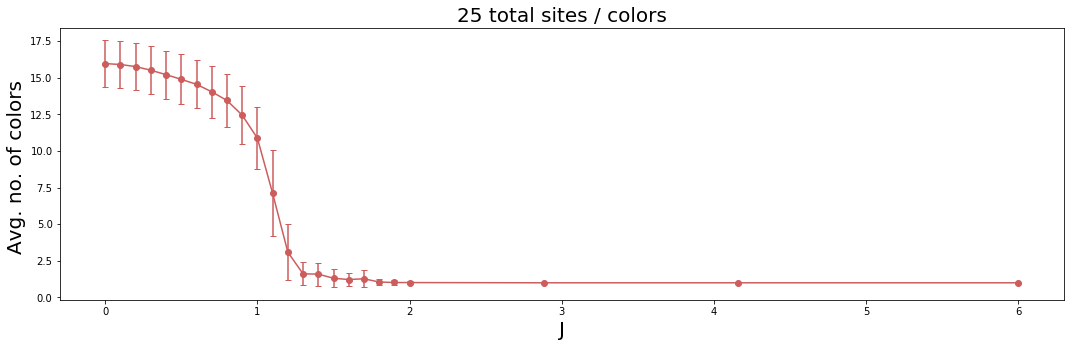

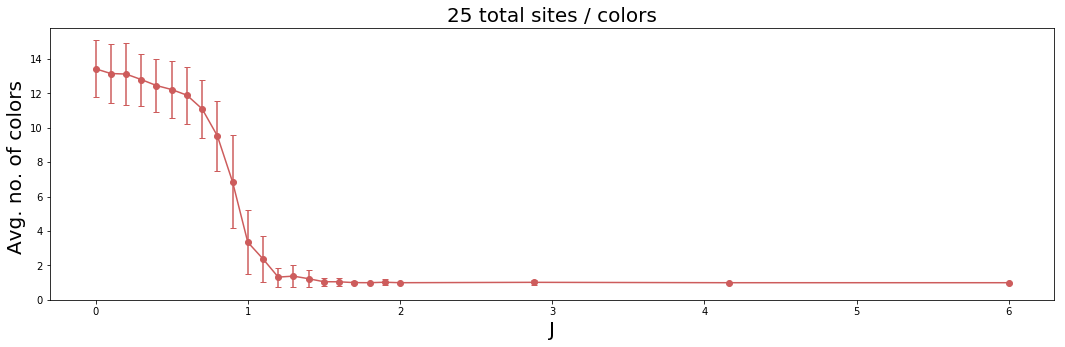

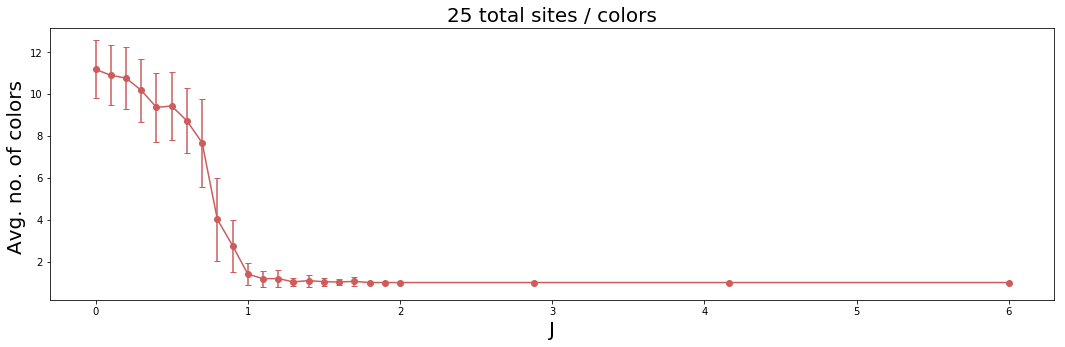

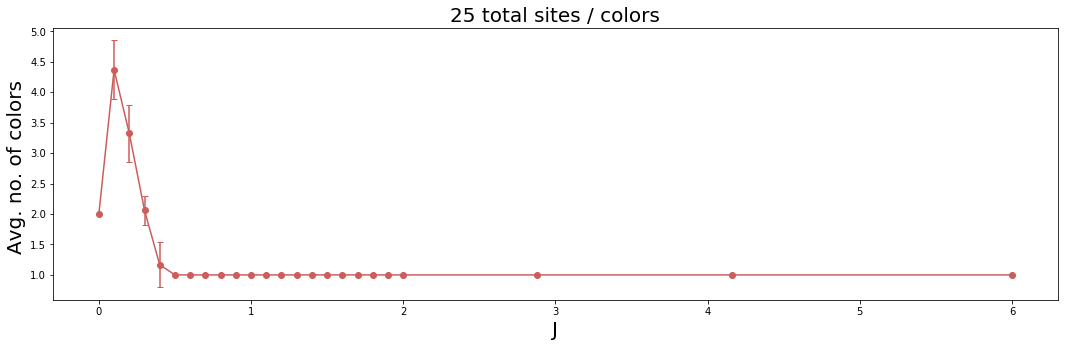

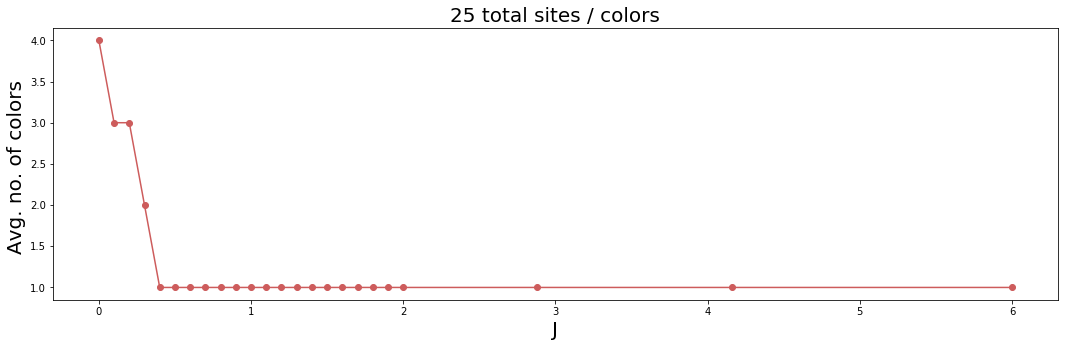

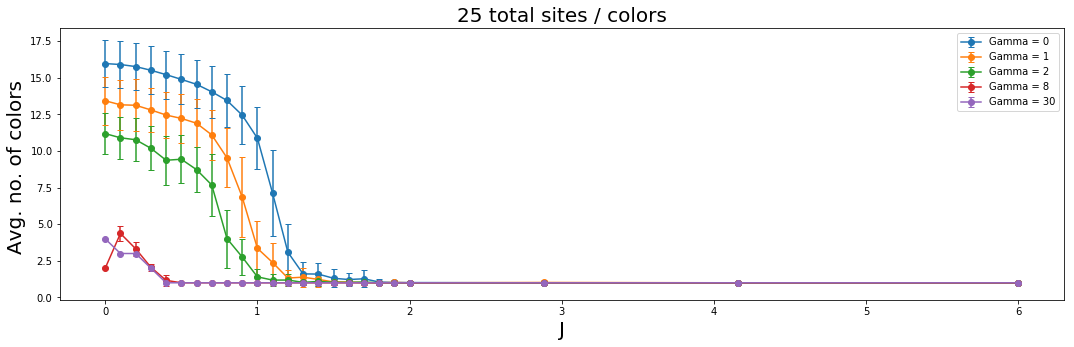

In [99]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[21 32 31 13 25 21]
 [ 2 24 12 10  4 36]
 [12 32 19  7  6 26]
 [30 31 28  3 22 28]
 [18 33 18  3  4 19]
 [23 15 10 31  4 27]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
101 num. cols: 22.900990099009903 avg. sites per col: 1.585088123

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 22.0 avg. sites per col: 1.6363636363636365
101 num. cols: 21.782178217821784 avg. sites per col: 1.6650305458035928
201 num. cols: 21.781094527363184 avg. sites per col: 1.6661256924457424
301 num. cols: 21.893687707641195 avg. sites per col: 1.6567954930377249
401 num. cols: 21.90773067331671 avg. sites per col: 1.6563124393128357
501 num. cols: 21.860279441117765 avg. sites per col: 1.6596977727817208
601 num. cols: 21.848585690515808 avg. sites per col: 1.660795802090785
701 num. cols: 21.87731811697575 avg. sites per col: 1.6588155400022042
801 num. cols: 21.85143570536829 avg. sites per col: 1.660394611517549
901 num. cols: 21.862375138734738 avg. sites per col: 1.6595206724354858
1001 num. cols: 21.857142857142858 avg. sites per col: 1.6600563923995517
Final configuration:
[[14 36 24  7 32 34]
 [14  4 12 16 16 36]
 [32  5 30 31  9 34]
 [34 35 

901 num. cols: 19.21198668146504 avg. sites per col: 1.8976049613441073
1001 num. cols: 19.087912087912088 avg. sites per col: 1.912553757505596
Final configuration:
[[12 12 25 35 31 31]
 [26 18 18 18 36 24]
 [26 26  6  6  5  5]
 [26 15 10  4 19 23]
 [24 29  5  9  9 34]
 [10 23 24 24 28 34]]
Final averages: 19.082587064676616 1.9130311862913965
Final stds: 2.2004398641302543 0.23363977494780488
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[15 20 15  1 20  9]
 [35 22 16 22 24 20]
 [23 23  5 30 33 17]
 [ 4  5 31 24 27 33]
 [ 5 18 28 35 18 20]
 [14 28  2 27 13 14]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 13.198019801980198 avg. sites per col: 2.8212598700076867
201 num.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0693069306930694 avg. sites per col: 34.75247524752475
201 num. cols: 1.0348258706467661 avg. sites per col: 35.37313432835821
301 num. cols: 1.089700996677741 avg. sites per col: 34.38538205980066
401 num. cols: 1.0897755610972568 avg. sites per col: 34.38403990024938
501 num. cols: 1.0718562874251496 avg. sites per col: 34.706586826347305
601 num. cols: 1.059900166389351 avg. sites per col: 34.92179700499168
701 num. cols: 1.0513552068473608 avg. sites per col: 35.0756062767475
801 num. cols: 1.0724094881398252 avg. sites per col: 34.69662921348315
901 num. cols: 1.1576026637069923 avg. sites per col: 33.16315205327414
1001 num. cols: 1.1488511488511488 avg. sites per col: 33.32067932067932
Final configuration:
[[11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 1

301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[ 7 17 17 22 26  5]
 [ 3  6  6  3  1 30]
 [23  5  2  5  6 33]
 [31 22 35 33 30  6]
 [ 6 29 11 17  9 11]
 [ 8 32 34 30 35 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 n

901 num. cols: 19.13651498335183 avg. sites per col: 1.8990728993144392
1001 num. cols: 19.1018981018981 avg. sites per col: 1.9032183005977799
Final configuration:
[[35 22 21 30  3 20]
 [25  3  4 26 23 22]
 [25 23  8 15 17  8]
 [ 2  2  4 25 23 22]
 [15 25 15 15 15 27]
 [15 13 24 25 16 16]]
Final averages: 19.100497512437812 1.9033192085698143
Final stds: 1.8711876004461616 0.19110089429483512
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
Initial configuration
[[ 4  4 24 16  4  2]
 [ 8 31  1 26  8 28]
 [28  3 13 23 30 23]
 [35 29 12  7 35 10]
 [ 8 32 23  8 28 26]
 [10 32 31 11 12 34]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 19.0 avg. sites per col: 1.894736842105263
101 num. cols: 16.336633663366335 avg. sites per col: 2.2361997978112

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 15.782178217821782 avg. sites per col: 2.3236802693980163
201 num. cols: 15.17910447761194 avg. sites per col: 2.415365635704342
301 num. cols: 14.093023255813954 avg. sites per col: 2.6308458361218436
401 num. cols: 12.458852867830425 avg. sites per col: 3.200505682022084
501 num. cols: 12.379241516966069 avg. sites per col: 3.2055299936957566
601 num. cols: 12.675540765391014 avg. sites per col: 3.1087304056060905
701 num. cols: 12.315263908701855 avg. sites per col: 3.1833007516634972
801 num. cols: 12.41323345817728 avg. sites per col: 3.143029640744182
901 num. cols: 12.726970033296338 avg. sites per col: 3.0610950899881657
1001 num. cols: 12.785214785214785 avg. sites per col: 3.030303679210969
Final configuration:
[[28 21 24 16 16 10]
 [29 20 30 16 18 10]
 [27 16 16 35 35 35]
 [27  1 17 35 35 35]
 [1

901 num. cols: 1.7081021087680355 avg. sites per col: 25.251276359600446
1001 num. cols: 1.6543456543456543 avg. sites per col: 26.01938061938062
Final configuration:
[[29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]]
Final averages: 1.6517412935323383 26.059104477611942
Final stds: 0.7584413532401793 9.950442835918182
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
Initial configuration
[[10 35 24 11  6 11]
 [33 14 12 18  4 33]
 [25 28 19 20 32 15]
 [28 31 32 15 32 22]
 [ 4 33 29 34 10  9]
 [12  5 21 33 10 27]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial

901 num. cols: 15.589345172031077 avg. sites per col: 2.331276886729205
1001 num. cols: 15.627372627372628 avg. sites per col: 2.3246755472948744
Final configuration:
[[24 21  5 31 20 21]
 [14 19 24 14 12 13]
 [34 20  8 24 25 20]
 [30 13 21 21 20 14]
 [35 13 12 19 14 18]
 [13  5 20 30 16 35]]
Final averages: 15.630845771144278 2.324114942248573
Final stds: 1.477541248288035 0.22366656363665213
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
Initial configuration
[[16 16  6 30  1 21]
 [31 33 11  5 16 35]
 [30  5 36 32 15 15]
 [ 8 24 35 35 10 32]
 [ 9 36  3 14 30 36]
 [22  4 34 31  3  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 2.5714285714285716
101 num. cols: 15.435643564356436 avg. sites per col: 2.406793116456

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 5.142857142857143
101 num. cols: 6.217821782178218 avg. sites per col: 5.968033946251767
201 num. cols: 4.791044776119403 avg. sites per col: 8.76176261549396
301 num. cols: 4.451827242524917 avg. sites per col: 9.432937826293301
401 num. cols: 5.092269326683292 avg. sites per col: 8.405521909511934
501 num. cols: 5.9141716566866265 avg. sites per col: 7.564802064203276
601 num. cols: 6.507487520798669 avg. sites per col: 6.967061889857241
701 num. cols: 6.891583452211127 avg. sites per col: 6.553079445518825
801 num. cols: 7.610486891385768 avg. sites per col: 6.093980426564678
901 num. cols: 7.990011098779134 avg. sites per col: 5.786539431711442
1001 num. cols: 8.517482517482517 avg. sites per col: 5.484427824628771
Final configuration:
[[18 22 10 10 32 16]
 [ 3  3 10 10 32 29]
 [29  3 10 10 16 21]
 [10 18 27 27 18 21]
 [29

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.495049504950495 avg. sites per col: 27.08910891089109
201 num. cols: 1.5024875621890548 avg. sites per col: 26.955223880597014
301 num. cols: 1.3355481727574752 avg. sites per col: 29.960132890365447
401 num. cols: 1.2518703241895262 avg. sites per col: 31.466334164588527
501 num. cols: 1.2015968063872255 avg. sites per col: 32.37125748502994
601 num. cols: 1.1680532445923462 avg. sites per col: 32.97504159733777
701 num. cols: 1.144079885877318 avg. sites per col: 33.40656205420827
801 num. cols: 1.126092384519351 avg. sites per col: 33.73033707865169
901 num. cols: 1.1120976692563818 avg. sites per col: 33.98224195338513
1001 num. cols: 1.100899100899101 avg. sites per col: 34.183816183816184
Final configuration:
[[17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[30 13 33 29 28  4]
 [22 25 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 3.272727272727273
101 num. cols: 12.257425742574258 avg. sites per col: 2.953116190739954
201 num. cols: 12.587064676616915 avg. sites per col: 2.8732759777535835
301 num. cols: 12.285714285714286 avg. sites per col: 2.9489991735838843
401 num. cols: 11.915211970074813 avg. sites per col: 3.0471403907812817
501 num. cols: 11.497005988023952 avg. sites per col: 3.1776694363520637
601 num. cols: 11.156405990016639 avg. sites per col: 3.2845464020172708
701 num. cols: 10.971469329529244 avg. sites per col: 3.3409591834698746
801 num. cols: 10.812734082397004 avg. sites per col: 3.389369681504504
901 num. cols: 10.875693673695894 avg. sites per col: 3.3649214270745964
1001 num. cols: 10.894105894105895 avg. sites per col: 3.3541854748648197
Final configuration:
[[10 19 15  5 18 20]
 [ 3 33 24 15 10  3]
 [ 3 24 19  3 33 33]
 [26 2

901 num. cols: 2.0155382907880135 avg. sites per col: 24.936958934517207
1001 num. cols: 1.948051948051948 avg. sites per col: 25.430769230769236
Final configuration:
[[11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]]
Final averages: 1.944278606965174 25.472835820895526
Final stds: 1.3146248171780222 11.444660203868024
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 8  4 34  4 35  1]
 [13 19 23 14 13 21]
 [16 14 22 25  1 25]
 [26  6 25 16 17  1]
 [33 16 12 20 36 20]
 [16 12 31 13 18  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0594059405940595 avg. sites per col: 34.93069306930693
201 num. co

801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

14  - param: 1.4
edge probabilities: [0.93918994 0.06081006]
Initial configuration
[[26 10 27 30  6 28]
 [ 5 20 34 33  3 18]
 [33 20  4 36 16 24]
 [19 10 19 32  3 27]
 [ 7 12  2  1  4 19]
 [36 28 25 35  5 30]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols

101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[34  3  5  1 19  6]
 [32 28 12 25 13 29]
 [23  8 27 17  2  8]
 [ 2  5 25 12 30 12]
 [21 31 14 29 36 22]
 [12  1  6 19  6 32]]
equilibration step: 0
equilibrati

101 num. cols: 5.0 avg. sites per col: 7.200000000000007
201 num. cols: 5.447761194029851 avg. sites per col: 6.662686567164185
301 num. cols: 5.631229235880399 avg. sites per col: 6.442524916943525
401 num. cols: 5.723192019950124 avg. sites per col: 6.3321695760598535
501 num. cols: 5.778443113772455 avg. sites per col: 6.265868263473056
601 num. cols: 5.815307820299501 avg. sites per col: 6.221630615640601
701 num. cols: 5.841654778887304 avg. sites per col: 6.190014265335236
801 num. cols: 5.861423220973783 avg. sites per col: 6.166292134831462
901 num. cols: 5.876803551609323 avg. sites per col: 6.147835738068813
1001 num. cols: 5.889110889110889 avg. sites per col: 6.133066933066933
Final configuration:
[[13 13 12 13 27 12]
 [13 12 27 13 12 12]
 [ 6 13 12 27 27  3]
 [13 13 12  6 21 12]
 [13 13 13  3 13 21]
 [12  6  6  3  3  6]]
Final averages: 5.88955223880597 6.132537313432836
Final stds: 0.313447050139663 0.3761364601675956
------------------------------------------------------

701 num. cols: 1.0185449358059915 avg. sites per col: 35.66619115549216
801 num. cols: 1.0162297128589264 avg. sites per col: 35.70786516853933
901 num. cols: 1.0144284128745837 avg. sites per col: 35.74028856825749
1001 num. cols: 1.0129870129870129 avg. sites per col: 35.76623376623377
Final configuration:
[[13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]]
Final averages: 1.0129353233830847 35.767164179104476
Final stds: 0.11299557863942998 2.03392041550974
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[16  9 20  6 34 35]
 [ 3 33 20 23 11 23]
 [11 30 17 18  8 15]
 [ 4 11 10 18 19 15]
 [36 19 32 33 13 32]
 [34  9 32  8 17 30]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilib

901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[18  7 30 14 31 16]
 [20  2 23 17 33 22]
 [10  9 35  9 26 12]
 [24 27 25 36 16 17]
 [ 8 30 17 20 30 34]
 [23 12  7 10 28  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

GAMMA: 16 ###################################################################

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[21 23 28 30  5 24]
 [ 5 21 19

301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[22 31 10 34 33  4]
 [ 8  8  3 21 10  1]
 [ 6  3 27  6  7 20]
 [ 6  4 11 20 16  4]
 [17 36  4 27 31 21]
 [ 1 16 33 19 12 12]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000


601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
Initial configuration
[[34  3  3 11 33 25]
 [16 29  9 31 10 21]
 [20 10 13 21 27  5]
 [23 24  1  4 19 18]
 [ 7 12 11  3  9  5]
 [28 19 17  7  5 34]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 av

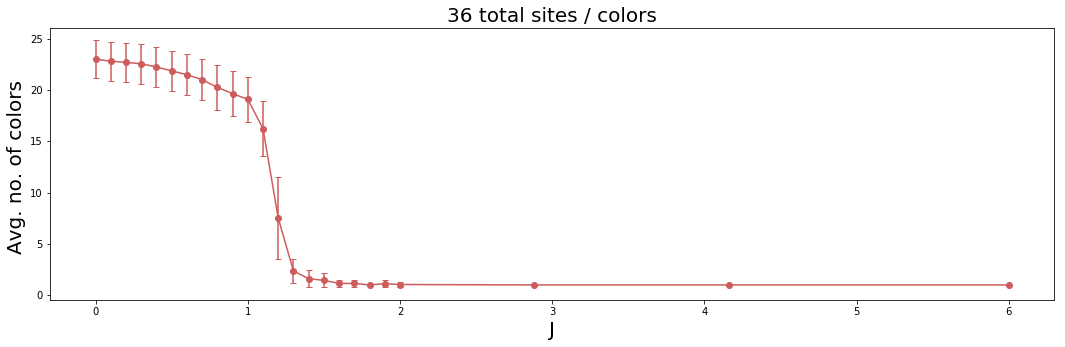

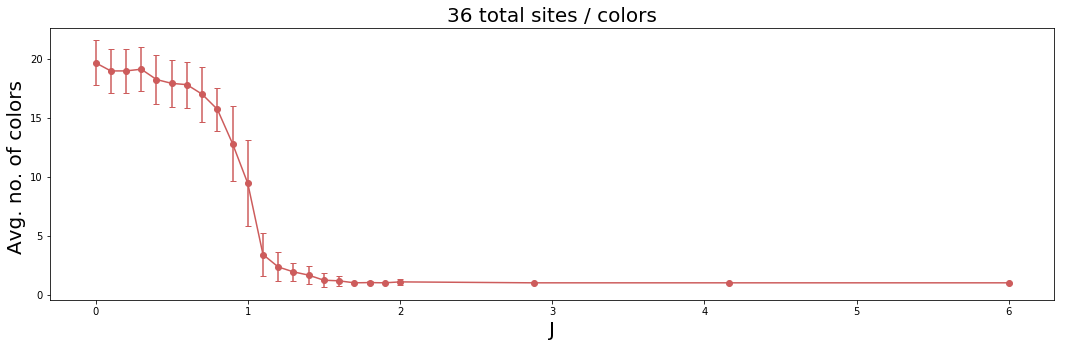

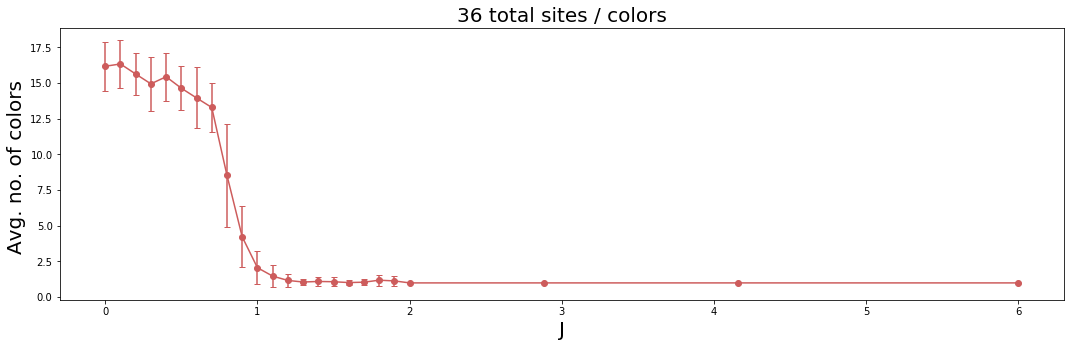

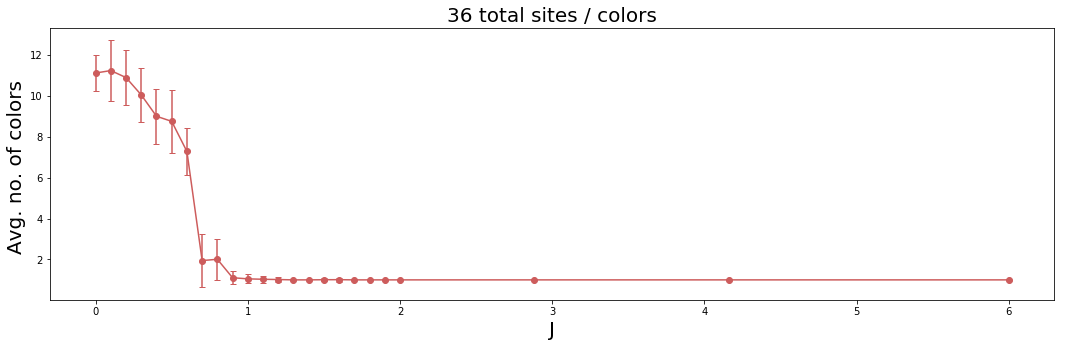

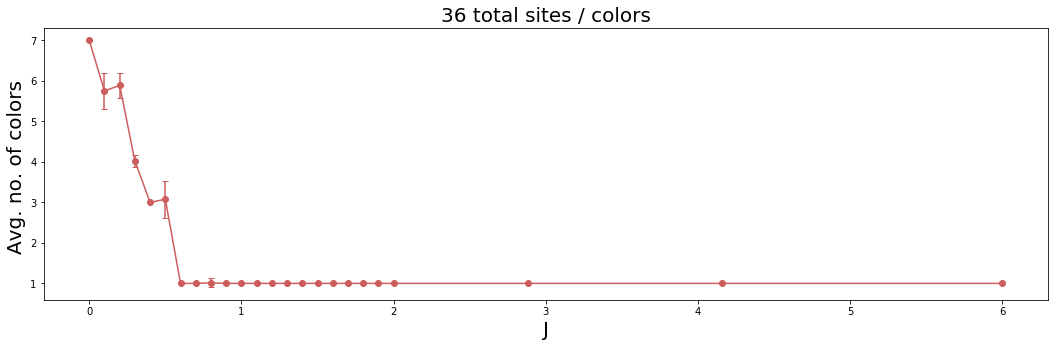

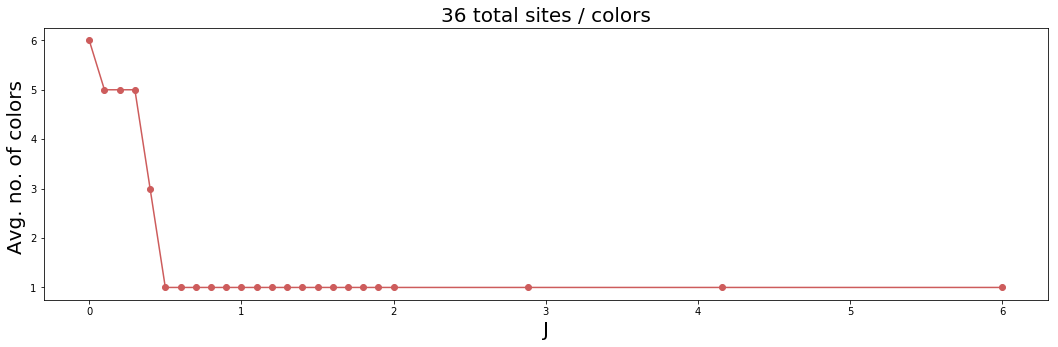

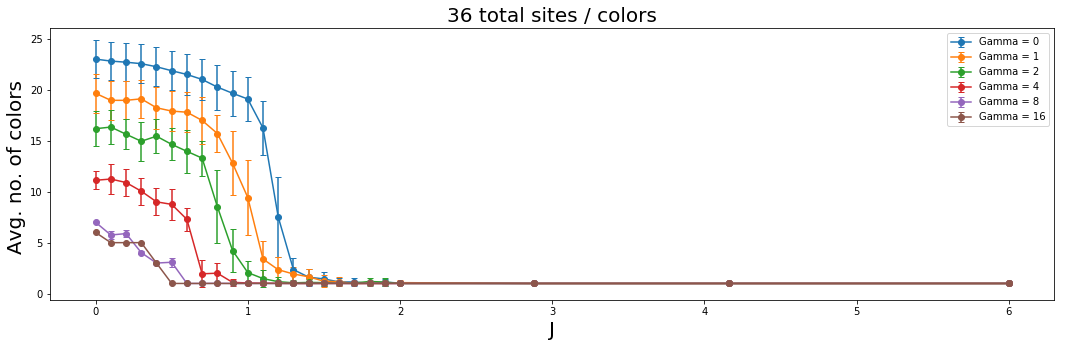

In [31]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[48 28 41 10 13 31 32]
 [22 32  8 45 48 22 21]
 [37 24 20 43 29 18 37]
 [31  3 18 26 12 48 14]
 [17 24 17  5 30 16 19]
 [40 37 17  3 44 24 34]
 [45 24 24 48  9 41 44]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 29.0 avg. sites per col: 1.6896551724137931
101 num. cols: 30.435643564356436 avg. sites per col: 1.6173127455958187
201 num. cols: 30.258706467661693 avg. sites per col: 1.628355795274019
301 num. cols: 30.13621262458472 avg. sites per col: 1.6350214409229555
401 num. cols: 30.107231920199503 avg. sites per col: 1.6365559774795013
501 num. cols: 30.03393213572854 avg. sites per col: 1.6403336378135083
601 num. cols: 30.104825291181363 avg. sites per col: 1.636632955853745
701 num. cols: 30.121255349500714 avg. sites per col: 1.635740218120796
801 num. cols: 30.082397003745317 avg. sites per col: 1.6378987675499443
901 num. cols: 30.09211986681465 avg. sites per col: 1.6373726591358368
1001 num. cols: 30.055944055944057 avg. sites per col: 1.6396780808131475
Final configuration:
[[ 2 43 33  5 48 22 17]
 [22 41 37 24 32 21 22]
 [41 38 30 30 30 46 14]


201 num. cols: 26.19402985074627 avg. sites per col: 1.8834649208912269
301 num. cols: 26.358803986710964 avg. sites per col: 1.8756187574902425
401 num. cols: 26.384039900249377 avg. sites per col: 1.8747786798325823
501 num. cols: 26.481037924151696 avg. sites per col: 1.8668870532874249
601 num. cols: 26.565723793677204 avg. sites per col: 1.860775886367085
701 num. cols: 26.55206847360913 avg. sites per col: 1.8618269678764638
801 num. cols: 26.637952559300874 avg. sites per col: 1.855367537732594
901 num. cols: 26.64816870144284 avg. sites per col: 1.8555773594257792
1001 num. cols: 26.62037962037962 avg. sites per col: 1.857725856340888
Final configuration:
[[ 5  5 10 10  3  3 24]
 [38  5 10 10 10  7 12]
 [27  8  3 46 21  8  2]
 [27 39 43 43  9 46  2]
 [26 11 47  9  9 43 12]
 [16 48 42  1  1 39  2]
 [16 48  5  5  7  7  2]]
Final averages: 26.603980099502486 1.8590039773303402
Final stds: 2.5314703963829346 0.1822162771519094
-------------------------------------------------------

601 num. cols: 1.519134775374376 avg. sites per col: 37.28674431503047
701 num. cols: 1.6904422253922968 avg. sites per col: 34.752020922491596
801 num. cols: 1.8277153558052435 avg. sites per col: 32.7737203495629
901 num. cols: 1.8501664816870145 avg. sites per col: 32.2995745467997
1001 num. cols: 1.852147852147852 avg. sites per col: 32.377039627039444
Final configuration:
[[16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [ 9 16 16 16 16 16 16]
 [35 16 16 16 16 16 16]]
Final averages: 1.8567164179104478 32.313184079601804
Final stds: 0.8519028535108943 13.911070772139524
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[41 28 23 14 15 39  3]
 [ 7 31  7 41  2 49 26]
 [ 8 39  6 26 31 29 49]
 [30 15 17 45 24  8 23]
 [ 3 12 34 20 47 17 21]
 [11 26 43 23  5 42 13]


101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial configuration
[[25 25 48 41 17 32 44]
 [32 12 48 29 14 24 44]
 [ 4  3  7 36 23 48  3]
 [37  9 48 37 45 19 27]
 [ 9 18 47 14 

201 num. cols: 26.65671641791045 avg. sites per col: 1.847575702839909
301 num. cols: 26.19933554817276 avg. sites per col: 1.8814405384938702
401 num. cols: 26.164588528678305 avg. sites per col: 1.8839160255044347
501 num. cols: 26.22554890219561 avg. sites per col: 1.8794046283708858
601 num. cols: 26.277870216306155 avg. sites per col: 1.8755248482938234
701 num. cols: 26.16119828815977 avg. sites per col: 1.8842552012889489
801 num. cols: 26.16729088639201 avg. sites per col: 1.884376678361455
901 num. cols: 26.195338512763595 avg. sites per col: 1.8836956833589884
1001 num. cols: 26.16883116883117 avg. sites per col: 1.8853733784037294
Final configuration:
[[ 1  4 12 34 15 20 13]
 [25 22  7 18 25 12 42]
 [46  2 12 31 38 45 34]
 [34 43 34  7  1  8  4]
 [40 19 45 16 12 20  9]
 [18 19 43 18 19 46 47]
 [44  9  6 44  4 43 49]]
Final averages: 26.16915422885572 1.8853064644740083
Final stds: 2.162834831546729 0.15683704235468585
---------------------------------------------------------

601 num. cols: 23.44758735440932 avg. sites per col: 2.109343420298476
701 num. cols: 23.51925820256776 avg. sites per col: 2.1018525094393
801 num. cols: 23.49812734082397 avg. sites per col: 2.1062557708472465
901 num. cols: 23.359600443951166 avg. sites per col: 2.119457688500696
1001 num. cols: 23.442557442557444 avg. sites per col: 2.111551656820151
Final configuration:
[[19  1 34 39 24 36 23]
 [26 37 37 39 34 34 25]
 [24 30  6 19 35 22 37]
 [35 30 43  9 40  3  1]
 [26 40 36 42  3  3 39]
 [34 14 42 42 46 23 23]
 [39 14  1 42 22 24 40]]
Final averages: 23.4318407960199 2.1125504561959914
Final stds: 2.337788446465 0.21644567474291723
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[49 32  2 19  5  9 47]
 [37 31 43 15 48 38 17]
 [ 2 45 24 13 22 22 44]
 [ 3 21 39  7  3 36 12]
 [42  9 10 45 44 25 32]
 [21 27 33 36 26  4 41]
 [15 4

1001 num. cols: 2.6723276723276723 avg. sites per col: 21.978205128205143
Final configuration:
[[23 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [ 8 19 19 19 19 19 19]]
Final averages: 2.67363184079602 21.955737976782764
Final stds: 1.0187062538450324 10.82292745393732
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[24 32 12 13 11 13 12]
 [17 40 35 21 28  6 18]
 [11 23 35 48 42 17 16]
 [17 42 32 48 17  5  8]
 [14 47 38 17 23 29 13]
 [ 4 34 34 10  3 22 17]
 [13 34 46  2 49 31 13]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 24.5
101 num. cols: 1.8613861386138615 avg. sites per col: 32.74752475247525


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 22.0 avg. sites per col: 2.227272727272727
101 num. cols: 20.396039603960396 avg. sites per col: 2.411519346442651
201 num. cols: 20.55223880597015 avg. sites per col: 2.3978582304022
301 num. cols: 20.74418604651163 avg. sites per col: 2.374081682129156
401 num. cols: 20.48379052369077 avg. sites per col: 2.4039526925238346
501 num. cols: 20.90818363273453 avg. sites per col: 2.3579894954330185
601 num. cols: 21.512479201331114 avg. sites per col: 2.298923132602278
701 num. cols: 21.671897289586305 avg. sites per col: 2.285473497955202
801 num. cols: 21.737827715355806 avg. sites per col: 2.277591057680148
901 num. cols: 22.033296337402884 avg. sites per col: 2.2482642868217564
1001 num. cols: 21.84015984015984 avg. sites per col: 2.269747010554635
Final configuration:
[[10  5 48 42 34 10 48]
 [10 39 42 10 48  5 25]
 [24 24 45  5 34 33 26]
 [29 24 3

301 num. cols: 20.900332225913623 avg. sites per col: 2.3568682116155806
401 num. cols: 20.546134663341647 avg. sites per col: 2.3991582061867134
501 num. cols: 20.25748502994012 avg. sites per col: 2.4338028084714485
601 num. cols: 20.224625623960065 avg. sites per col: 2.4376270505691617
701 num. cols: 20.067047075606276 avg. sites per col: 2.4586139791044963
801 num. cols: 20.2334581772784 avg. sites per col: 2.438143005147145
901 num. cols: 20.065482796892343 avg. sites per col: 2.459799502703328
1001 num. cols: 20.066933066933068 avg. sites per col: 2.4589811969643702
Final configuration:
[[ 7 38 17 26 26  1  1]
 [ 7 49 17 17 26 12 12]
 [26 17 46 18 18 31 31]
 [30 30 32 17 31 32 44]
 [22 38  7  1 43 45  7]
 [18 48 30 46 45 13 32]
 [10  1 48 40 17  7 44]]
Final averages: 20.066666666666666 2.4589454509068
Final stds: 1.676448904288432 0.2053937654677155
------------------------------------------------------------------------------------------------------------------------

6  - par

801 num. cols: 2.7765293383270913 avg. sites per col: 27.918556665279397
901 num. cols: 2.7436182019977804 avg. sites per col: 27.10406646935487
1001 num. cols: 2.739260739260739 avg. sites per col: 26.60569153069134
Final configuration:
[[37 37 37 37 37 37 17]
 [37 37 37 37 37 37 32]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]]
Final averages: 2.7402985074626867 26.56480652294066
Final stds: 1.7583398746753698 15.918299012324399
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[25 44 40 24 27 41 25]
 [29 36  4 14 37 36 17]
 [36 36 41 22 12 41 38]
 [ 6 49 16 13  8 42 40]
 [ 7 21 15 12 29 15 19]
 [31 39 38 38 44 41 46]
 [42 40 41 14 45 27 49]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0748129675810474 avg. sites per col: 47.16708229426434
501 num. cols: 1.1676646706586826 avg. sites per col: 44.89221556886228
601 num. cols: 1.139767054908486 avg. sites per col: 45.5757071547421
701 num. cols: 1.1198288159771754 avg. sites per col: 46.0641940085592
801 num. cols: 1.104868913857678 avg. sites per col: 46.43071161048689
901 num. cols: 1.0932297447280799 avg. sites per col: 46.71587125416204
1001 num. cols: 1.083916083916084 avg. sites per col: 46.94405594405595
Final configuration:
[[38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]]
Final avera

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 3.5
101 num. cols: 14.009900990099009 avg. sites per col: 3.4976897689768975
201 num. cols: 14.348258706467663 avg. sites per col: 3.4187396351575403
301 num. cols: 13.87375415282392 avg. sites per col: 3.5488968395945126
401 num. cols: 13.680798004987532 avg. sites per col: 3.5978003708676902
501 num. cols: 13.50499001996008 avg. sites per col: 3.6459900711397513
601 num. cols: 13.582362728785357 avg. sites per col: 3.623042791927966
701 num. cols: 13.593437945791726 avg. sites per col: 3.6185485935842507
801 num. cols: 13.565543071161049 avg. sites per col: 3.6249239732385883
901 num. cols: 13.766925638179801 avg. sites per col: 3.5771336691425617
1001 num. cols: 13.88011988011988 avg. sites per col: 3.551835005115571
Final configuration:
[[35 43 34  2  7 43 12]
 [ 1  1 12  2  2 43 43]
 [12 12 41 41 12 20 38]
 [ 1 43 40 12 

301 num. cols: 1.3521594684385383 avg. sites per col: 41.38953488372092
401 num. cols: 1.2643391521197007 avg. sites per col: 43.28740648379051
501 num. cols: 1.467065868263473 avg. sites per col: 39.57002661343967
601 num. cols: 1.4692179700499168 avg. sites per col: 39.182334997226754
701 num. cols: 1.4022824536376606 avg. sites per col: 40.58285782215874
801 num. cols: 1.352059925093633 avg. sites per col: 41.63368705784429
901 num. cols: 1.3129855715871255 avg. sites per col: 42.451257861635156
1001 num. cols: 1.2817182817182817 avg. sites per col: 43.1054778554778
Final configuration:
[[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]]
Final averages: 1.2805970149253731 43.12893864013262
Final stds: 0.573781765325411 11.194430043211911
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilitie

501 num. cols: 7.0 avg. sites per col: 7.0
601 num. cols: 7.0 avg. sites per col: 7.0
701 num. cols: 7.0 avg. sites per col: 7.0
801 num. cols: 7.0 avg. sites per col: 7.0
901 num. cols: 7.0 avg. sites per col: 7.0
1001 num. cols: 7.0 avg. sites per col: 7.0
Final configuration:
[[19  1 12 21 43 12 30]
 [19 12 30 30 43 21 21]
 [35 12 19 30  1 12 43]
 [35 30 35 30 21 43 43]
 [21 19  1 12 43 43 35]
 [ 1 19  1 12 43 35 43]
 [ 1 19 21 35 21 30 21]]
Final averages: 7.0 7.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
Initial configuration
[[22 27 24 28  3 49 12]
 [27 35  6 37 26 17 22]
 [37 23 45 13  4 19 19]
 [46  8  2 47 44  2 21]
 [25 43 16 24  5 22 33]
 [49 47 48 35 21 36 15]
 [ 6  2 11  3  9  3 33]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibratio

601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[16 43 37 29 23 10 47]
 [32  1 17 37 31 12 30]
 [49 22  9 28 29 41  9]
 [21 35 31 42 34 17 41]
 [35 22  7 21 13 38  7]
 [ 4 39  1 40 45 37 32]
 [17  5  3 29  8 30  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. si

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
I

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 7.0
101 num. cols: 7.0 avg. sites per col: 7.0
201 num. cols: 7.0 avg. sites per col: 7.0
301 num. cols: 7.0 avg. sites per col: 7.0
401 num. cols: 7.0 avg. sites per col: 7.0
501 num. cols: 7.0 avg. sites per col: 7.0
601 num. cols: 7.0 avg. sites per col: 7.0
701 num. cols: 7.0 avg. sites per col: 7.0
801 num. cols: 7.0 avg. sites per col: 7.0
901 num. cols: 7.0 avg. sites per col: 7.0
1001 num. cols: 7.0 avg. sites per col: 7.0
Final configuration:
[[20 29 17 18 20 29 28]
 [29 20 18 48 48 29 48]
 [11 11 17 29 28 28 20]
 [11 20 20 20 18 29 20]
 [48 11 48 18 18 48 28]
 [11 20 11 11 18 48 28]
 [20 18 28 28 28 20 48]]
Final averages: 7.0 7.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925

201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]
 [31 31 31 31 31 31 31]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
Initial configuration
[[43 22 39 28 33 14 30]
 [ 6 35 15 32 49  6 15]
 [11 33  4 22 13 40  8]
 [ 9  5 28 28 32  3 49]
 [ 1 49 32 41 48 27 44]
 [17 10 26  1 23 16 15]
 [ 5 40 18 22 31 18 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

14  - param: 1.4
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilitie

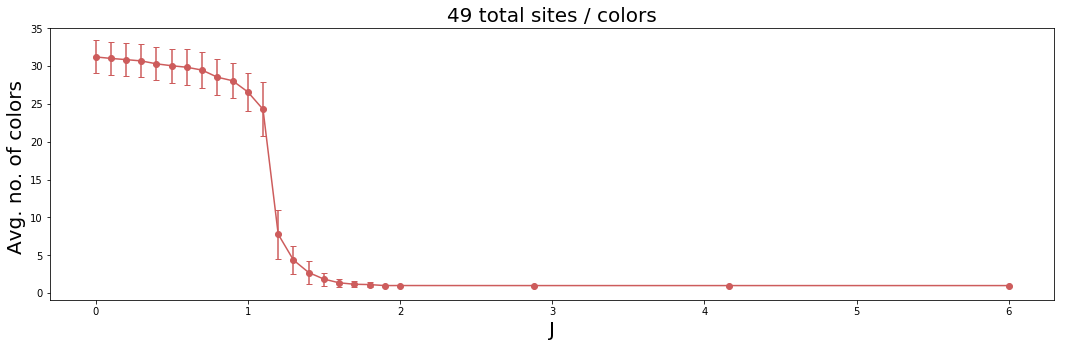

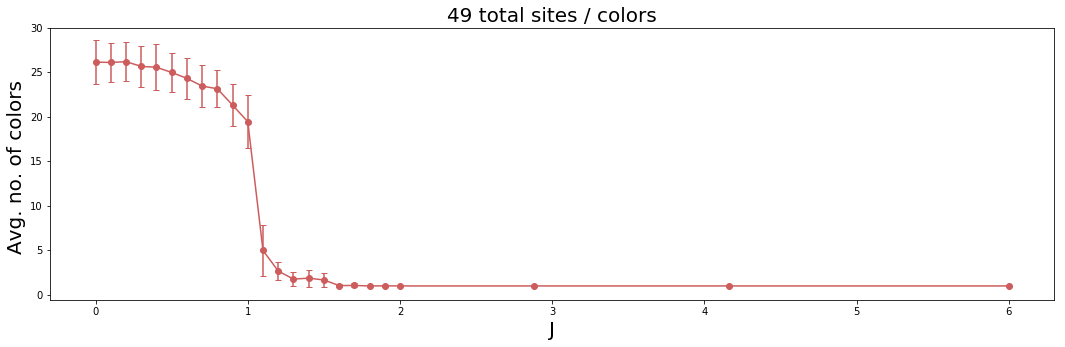

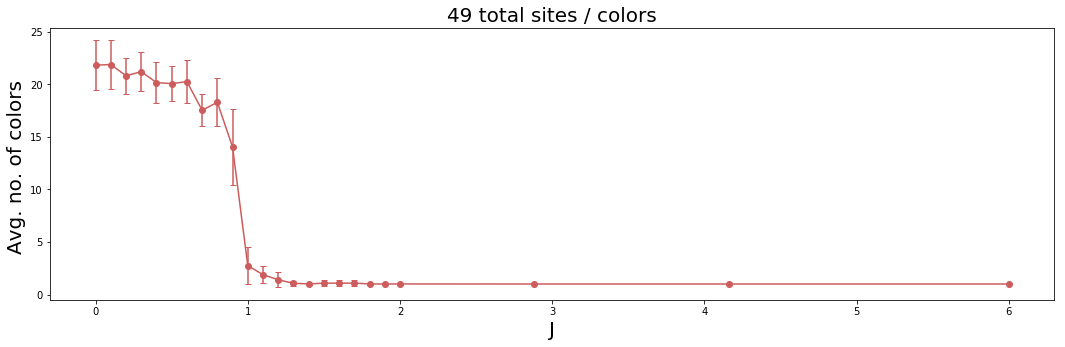

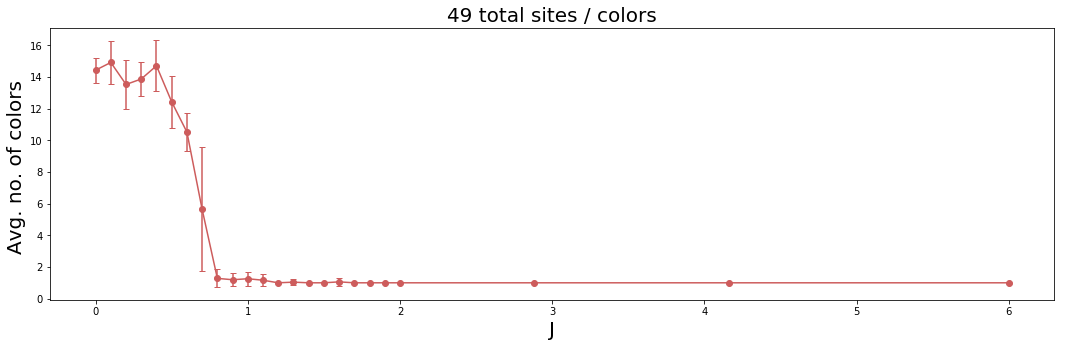

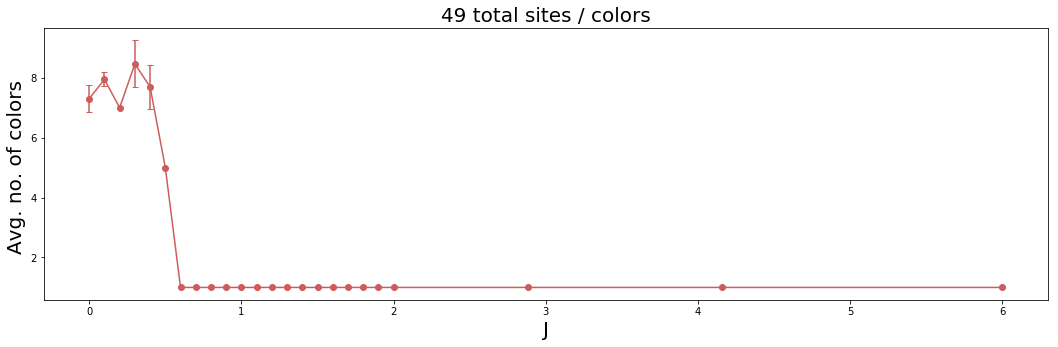

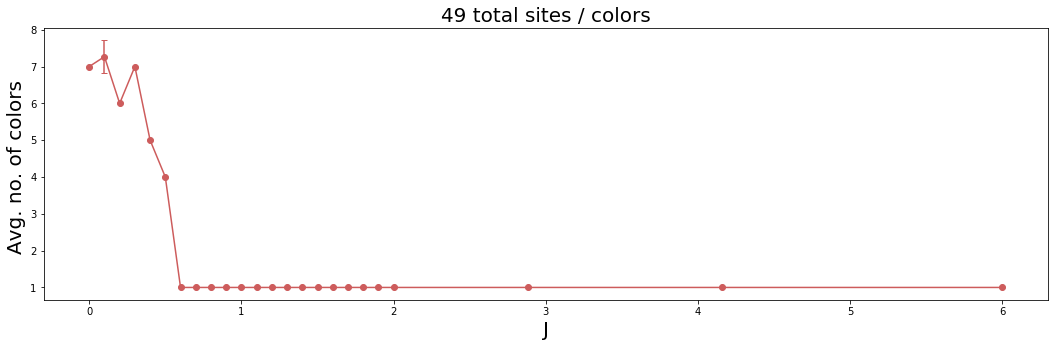

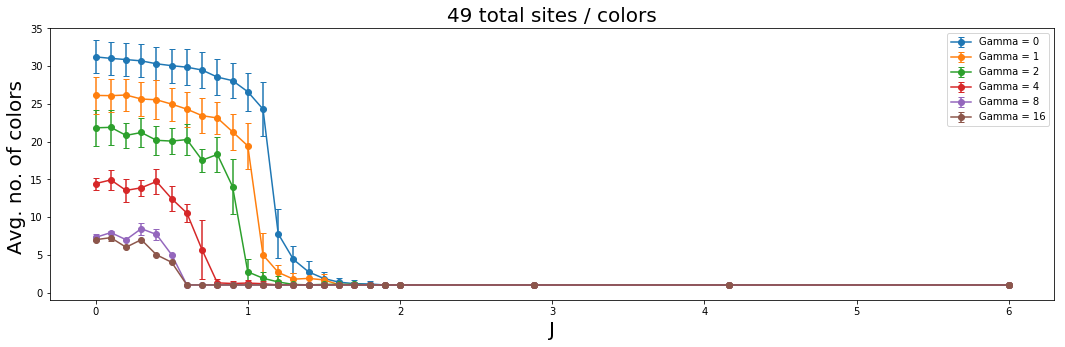

In [32]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 7

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

In [33]:
sorted(bell_dict.keys())

[(1, 1),
 (2, 1),
 (2, 2),
 (3, 1),
 (3, 2),
 (3, 3),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9),
 (10, 10),
 (11, 1),
 (11, 2),
 (11, 3),
 (11, 4),
 (11, 5),
 (11, 6),
 (11, 7),
 (11, 8),
 (11, 9),
 (11, 10),
 (11, 11),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11),
 (12, 12),
 (13, 2),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 8),
 (13, 9),
 (13, 10),
 (13, 11),
 (13, 12),
 (13, 13),
 (14, 2),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (14, 7),
 (14, 8),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 12),
 (14, 13),
 (14, 14),
 (15, 2),


## J (edges / neighbor interaction) with multiple box sizes (N)

N: 6 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[26 17  5  5 16  4]
 [23  3  2 10 29 21]
 [22 21 22 23 26  3]
 [26 36 23 35 28 18]
 [26  7 36  1 21  5]
 [24 16 15 28 35 20]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
101 num. cols: 22.900990099009903 avg. sites per col: 1.5818104752110

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
101 num. cols: 21.574257425742573 avg. sites per col: 1.6812423277594941
201 num. cols: 21.796019900497512 avg. sites per col: 1.6640025526910125
301 num. cols: 21.940199335548172 avg. sites per col: 1.6543549788416447
401 num. cols: 21.892768079800497 avg. sites per col: 1.657448440704158
501 num. cols: 21.95808383233533 avg. sites per col: 1.6525244895498528
601 num. cols: 21.90349417637271 avg. sites per col: 1.6565880643862794
701 num. cols: 21.902995720399428 avg. sites per col: 1.6566744813449275
801 num. cols: 21.923845193508114 avg. sites per col: 1.6545583765384122
901 num. cols: 21.943396226415093 avg. sites per col: 1.65343237305435
1001 num. cols: 21.906093906093908 avg. sites per col: 1.656243941528769
Final configuration:
[[ 4 29 24 16 28  1]
 [ 5 19 21 26 34 18]
 [15 15 14 10  5 14]
 [ 8 35  6

801 num. cols: 18.901373283395756 avg. sites per col: 1.9294369861667424
901 num. cols: 19.02219755826859 avg. sites per col: 1.916932668198544
1001 num. cols: 18.876123876123877 avg. sites per col: 1.9339468022494732
Final configuration:
[[19 19 23 23 23 23]
 [25 13 23 23 23 23]
 [31 13 23 23 23 23]
 [35  7 29 31  3  3]
 [ 8 24 28  3 25 27]
 [24 24  3  3 14  3]]
Final averages: 18.856716417910448 1.9365693309683099
Final stds: 2.1998116527650495 0.23877702788440877
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[32 13 26  9 34  1]
 [15 21  1 32 33 33]
 [17 24 35  3 24 13]
 [19 35  4 20 36  1]
 [23 13  4 15 22  2]
 [12  2 32 11  7  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 2.5714285714

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.1044776119402986 avg. sites per col: 34.11940298507463
301 num. cols: 1.2923588039867109 avg. sites per col: 30.857142857142858
401 num. cols: 1.2194513715710724 avg. sites per col: 32.13965087281795
501 num. cols: 1.1976047904191616 avg. sites per col: 32.51497005988024
601 num. cols: 1.2612312811980033 avg. sites per col: 31.63727121464226
701 num. cols: 1.223965763195435 avg. sites per col: 32.25962910128388
801 num. cols: 1.2072409488139826 avg. sites per col: 32.52434456928839
901 num. cols: 1.1886792452830188 avg. sites per col: 32.83018867924528
1001 num. cols: 1.1698301698301699 avg. sites per col: 33.14685314685315
Final configuration:
[[13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]
 [5 5 5 5 5 5]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[36 36  3  1 24 22]
 

301 num. cols: 29.53156146179402 avg. sites per col: 2.1752446497604017
401 num. cols: 29.58852867830424 avg. sites per col: 2.171073137562623
501 num. cols: 29.676646706586826 avg. sites per col: 2.1647033740278574
601 num. cols: 29.6522462562396 avg. sites per col: 2.1663153851331565
701 num. cols: 29.66904422253923 avg. sites per col: 2.1651299437954306
801 num. cols: 29.66916354556804 avg. sites per col: 2.1654788519758696
901 num. cols: 29.66814650388457 avg. sites per col: 2.165489768188905
1001 num. cols: 29.678321678321677 avg. sites per col: 2.164694108777853
Final configuration:
[[ 8 14 27 16 34 25 25 25]
 [ 4 17 17 26 12  6  3  8]
 [14 17 22  3 12  9 25  1]
 [14 13  5 12  6 34 10 14]
 [32 35  2  8  7 34 11  9]
 [12  2 33 18  8 17 11 28]
 [23 18 13 28  5 16 28  1]
 [ 6 35 25 13 26 32  8 35]]
Final averages: 29.67860696517413 2.164668197859103
Final stds: 1.811294045470107 0.13547974117319952
-------------------------------------------------------------------------------------

equilibration step: 5000
1 num. cols: 26.0 avg. sites per col: 2.4615384615384617
101 num. cols: 28.207920792079207 avg. sites per col: 2.280518641375478
201 num. cols: 28.17412935323383 avg. sites per col: 2.28198753325584
301 num. cols: 28.13621262458472 avg. sites per col: 2.2857395981915083
401 num. cols: 28.039900249376558 avg. sites per col: 2.2942099296622698
501 num. cols: 27.974051896207584 avg. sites per col: 2.298933449694563
601 num. cols: 27.888519134775375 avg. sites per col: 2.306382245048506
701 num. cols: 27.79315263908702 avg. sites per col: 2.3153715581732355
801 num. cols: 27.740324594257178 avg. sites per col: 2.3206581150082646
901 num. cols: 27.710321864594896 avg. sites per col: 2.3234591153971
1001 num. cols: 27.703296703296704 avg. sites per col: 2.3238233578726626
Final configuration:
[[33 33 28 35 33  9 35 11]
 [20  1 17 17  3 12 11  4]
 [18  2 24 14 14 29 20 33]
 [31 15  9 27 15 21  1 14]
 [32  6  6 12 15  1 24 30]
 [ 9 10 19 33  3  1 26 30]
 [ 6  3 23 13 3

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 32.0
101 num. cols: 3.594059405940594 avg. sites per col: 19.5047619047619
201 num. cols: 2.517412935323383 avg. sites per col: 37.23705283108269
301 num. cols: 2.2790697674418605 avg. sites per col: 38.68653694035758
401 num. cols: 2.9401496259351623 avg. sites per col: 32.368222301389295
501 num. cols: 3.3393213572854292 avg. sites per col: 28.738408896492615
601 num. cols: 3.0083194675540765 avg. sites per col: 32.77749782109174
701 num. cols: 2.958630527817404 avg. sites per col: 31.838815297873662
801 num. cols: 2.906367041198502 avg. sites per col: 31.23305392069422
901 num. cols: 2.9289678135405106 avg. sites per col: 30.258781248348193
1001 num. cols: 3.161838161838162 avg. sites per col: 28.537786023500157
Final configuration:
[[ 4  4  4  4  4  4  4  4]
 [ 4  4  4  4  4  4  4  5]
 [ 4  4  4  4  4  4  4  4]
 [ 4  4  4 

equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 64.0
101 num. cols: 1.0891089108910892 avg. sites per col: 61.148514851485146
201 num. cols: 1.044776119402985 avg. sites per col: 62.56716417910448
301 num. cols: 1.0299003322259137 avg. sites per col: 63.04318936877076
401 num. cols: 1.1496259351620948 avg. sites per col: 59.531172069825416
501 num. cols: 1.215568862275449 avg. sites per col: 57.357285429141704
601 num. cols: 1.194675540765391 avg. sites per col: 57.98336106489184
701 num. cols: 1.2196861626248217 avg. sites per col: 57.152639087018535
801 num. cols: 1.1922596754057428 avg. sites per col: 58.00749063670411
901 num. cols: 1.1709211986681465 avg. sites per col: 58.672586015538286
1001 num. cols: 1.1538461538461537 avg. sites per col: 59.2047952047952
Final configuration:
[[20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20]
 [2

N: 10 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[13  7 27  6 12 29 15  5  8 35]
 [18 33 10  7  5 16 10  7 16 27]
 [ 7  6 20 24  2 30 15 16  8 18]
 [14 25 28 30 27 27 34 15 33 15]
 [14  4 22  7  6 19 35 13  4  2]
 [34 18 26 13 33 22 25 31 27 11]
 [36  7 35 25  5  3 30 15  7 18]
 [26 30 29 32 22 23 36 17 31 18]
 [11 16  4 12 20  4 32  7  9 10]
 [26  6 20  6 34  6 28 35 16 24]]
equilibration step: 0
equilibration step: 1000
equilibration step: 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 33.0 avg. sites per col: 3.0303030303030303
101 num. cols: 33.603960396039604 avg. sites per col: 2.9803473028246144
201 num. cols: 33.56218905472637 avg. sites per col: 2.984278309106961
301 num. cols: 33.561461794019934 avg. sites per col: 2.984498159444736
401 num. cols: 33.55112219451372 avg. sites per col: 2.9854013576041605
501 num. cols: 33.572854291417165 avg. sites per col: 2.983226352959856
601 num. cols: 33.5324459234609 avg. sites per col: 2.9869287298832408
701 num. cols: 33.49643366619116 avg. sites per col: 2.9902215141602864
801 num. cols: 33.4669163545568 avg. sites per col: 2.9929368238484977
901 num. cols: 33.445061043285236 avg. sites per col: 2.9950372398283855
1001 num. cols: 33.43156843156843 avg. sites per col: 2.9963224125813297
Final configuration:
[[ 5 21 36 10  8 22 29 33 17 36]
 [24  4 36 20 10 35 25  6 16  6]
 [35  2  2 

601 num. cols: 32.36605657237937 avg. sites per col: 3.0973122102363293
701 num. cols: 32.33238231098431 avg. sites per col: 3.1009110221909997
801 num. cols: 32.33458177278402 avg. sites per col: 3.100811805283544
901 num. cols: 32.33296337402886 avg. sites per col: 3.1011491337114485
1001 num. cols: 32.33566433566433 avg. sites per col: 3.1008553601021065
Final configuration:
[[26 19 25 20 11  1 30  6 29 35]
 [31 18  9 24  6 31 16  2 21  5]
 [13  8 14 12  4 31 14  2  6  5]
 [10 22 30 28 24 32 34 34  8 13]
 [ 4 30 35 22 18 22 33 17 33 18]
 [ 4  4 15 25 25  3 12 29 33 12]
 [29 24 15 15 32 34  6 13  8 18]
 [15  4 15  7 25 21 28  5  9 14]
 [25 21  4  7 16 18 34  9  9  9]
 [35  6  8 22 29 31 14  9 27 25]]
Final averages: 32.33731343283582 3.100674323346368
Final stds: 1.6501622854818019 0.162529167968336
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initi

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 25.0
101 num. cols: 3.762376237623762 avg. sites per col: 29.306930693069294
201 num. cols: 4.223880597014926 avg. sites per col: 25.713101160862326
301 num. cols: 3.691029900332226 avg. sites per col: 30.65337763012177
401 num. cols: 3.6608478802992517 avg. sites per col: 31.093100581878634
501 num. cols: 3.632734530938124 avg. sites per col: 32.68795741849634
601 num. cols: 3.4775374376039934 avg. sites per col: 35.48807542983914
701 num. cols: 3.466476462196862 avg. sites per col: 34.97860199714685
801 num. cols: 3.4656679151061174 avg. sites per col: 34.49438202247179
901 num. cols: 3.596004439511654 avg. sites per col: 33.172665292532
1001 num. cols: 3.4245754245754245 avg. sites per col: 36.41548927263203
Final configuration:
[[11 11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11 1

1001 num. cols: 1.2567432567432568 avg. sites per col: 87.62903762903763
Final configuration:
[[2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]]
Final averages: 1.2557213930348259 87.67827529021558
Final stds: 0.4671066887730969 21.902956430523368
------------------------------------------------------------------------------------------------------------------------

18  - param: 1.8
edge probabilities: [0.97267628 0.02732372]
Initial configuration
[[ 3 23 28 18 17 30 30 22 21 11]
 [ 5  1 16 28 14 17  1 24 27 20]
 [36 17  6 35 27 16 12 22 34 32]
 [33 31 11  8 36 30 27 17 25 22]
 [23 25 29  8 34 22 27 26  4  3]
 [16 27 18 15 36  1 33 21  6 30]
 [12 34 21  5 36 19 32 36 10 25]
 [27 12  5  4  4 20  2 17 23 31]
 [29 27 33 27 10 27 12 25  3  1]
 [34 22 21  9  1 22  1 23 13 36]]
equilibration step: 0
equilibration 

201 num. cols: 1.0 avg. sites per col: 100.0
301 num. cols: 1.0 avg. sites per col: 100.0
401 num. cols: 1.0 avg. sites per col: 100.0
501 num. cols: 1.0 avg. sites per col: 100.0
601 num. cols: 1.0 avg. sites per col: 100.0
701 num. cols: 1.0 avg. sites per col: 100.0
801 num. cols: 1.0 avg. sites per col: 100.0
901 num. cols: 1.0 avg. sites per col: 100.0
1001 num. cols: 1.0 avg. sites per col: 100.0
Final configuration:
[[3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]]
Final averages: 1.0 100.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[20 13  6 31  4 14 23 28 16  6]
 [28 16 18  9  7 24  6 14  6  9]
 [26 18 19  8 35 

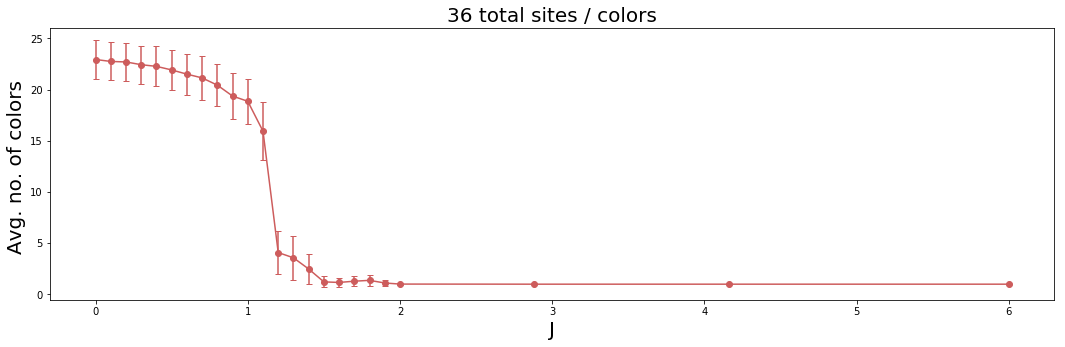

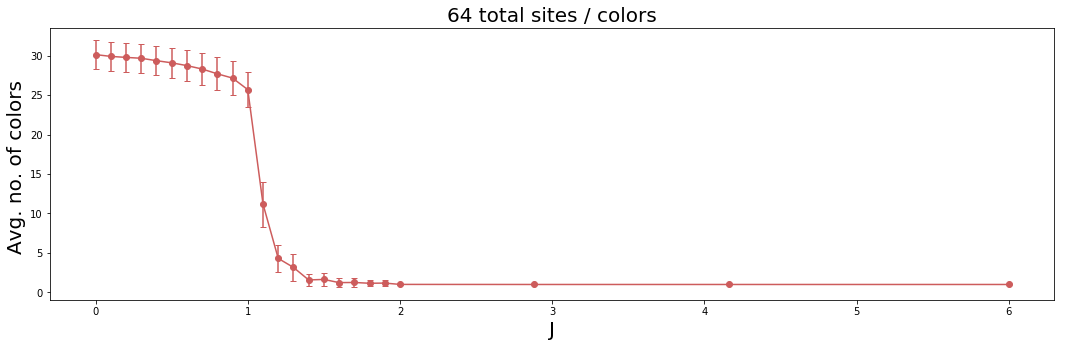

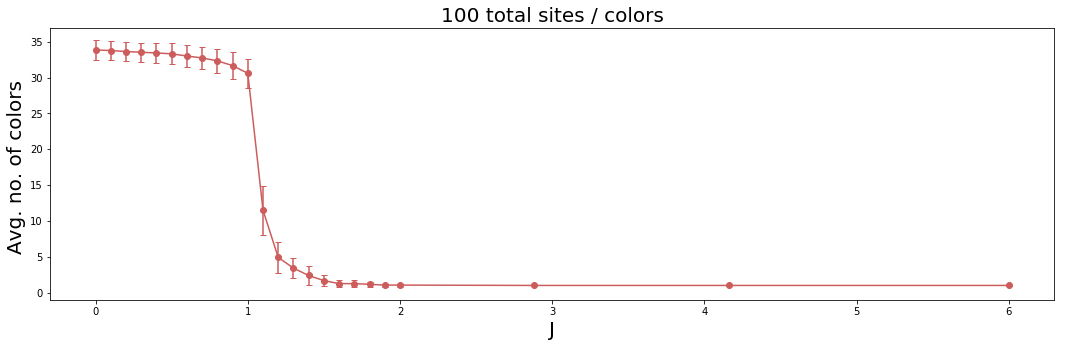

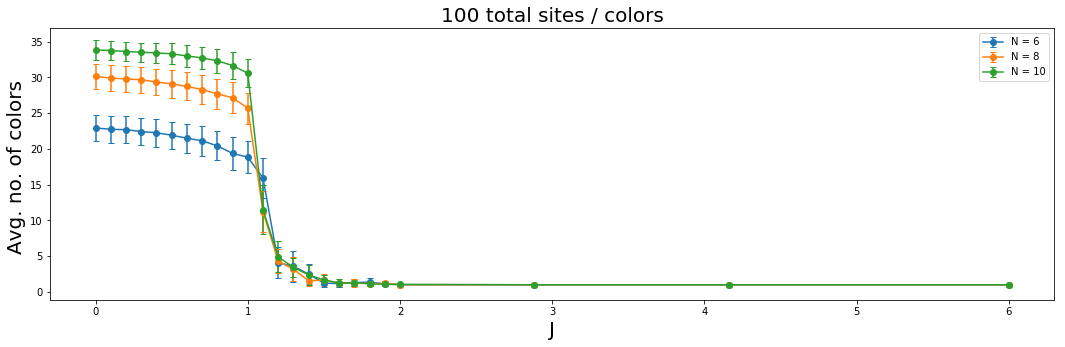

In [12]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
nN = 3
params, avg_c, std_c = [], [], []
Ns = [6,8,10]
for N in Ns:
    print("N:",N,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, 36, Js=Js, gamma=0, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Ns, "J", "N")

N: 6 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[25 28  7  6 23  6]
 [19 23 22 16 11 30]
 [32 23 28 21  9 32]
 [32 34 30 12  1 24]
 [ 3  7 15 31 17 36]
 [11  3 31 15 31 33]]
equilibration step: 0
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
Final configuration:
[[28 18 18 14 29 34]
 [16 22  6 16 34  1]
 [27 35  1 36 23 23]
 [35 27 26 21 13  4]
 [ 9 10 12 33 18 32]
 [20 31 30  1 21 25]]
Final averages: 22.733333333333334 1.596350102

1 num. cols: 12.0 avg. sites per col: 3.0
Final configuration:
[[36  7  7  7  7  7]
 [ 6 34  7  7  7  7]
 [31 31  7  7  7  7]
 [ 7 21 32  7  7 18]
 [14 17  9  9  9 17]
 [12  9  9  9  9 17]]
Final averages: 11.6 3.1304428904428905
Final stds: 1.0198039027185568 0.30923768168416726
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[28  1 31 28 28 36]
 [35 10 33  9 25 28]
 [21 36 33  1 22 26]
 [22 27 32  9 29 22]
 [25 34 32 36 11 18]
 [16 15  1 12 27 20]]
equilibration step: 0
1 num. cols: 13.0 avg. sites per col: 2.769230769230769
Final configuration:
[[10 19 19 19 19 22]
 [11 26 19 19 19  2]
 [11 35  6 11 11  4]
 [19 19  2 11 11 11]
 [19 19 18 11  5 24]
 [34 34 34 20 21  7]]
Final averages: 13.266666666666667 2.755864135864136
Final stds: 1.6519348924485155 0.34200101206108463
---------------------------------------------------------

1 num. cols: 30.0 avg. sites per col: 2.1333333333333333
Final configuration:
[[ 9 29 14 25 18 25  8  9]
 [ 5 21 22  7 19 15  8  9]
 [23 12 19 16 16 10  9 25]
 [17 33 32  6 35 15 14 23]
 [ 6 27 19  3 31 22 31 32]
 [20 25 30 32 11 26 22 36]
 [16 35 27 30 23  6 20  5]
 [11 33 24 32  1  3  3  9]]
Final averages: 30.6 2.0991162039734528
Final stds: 1.8547236990991405 0.1260869855117362
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[ 7 11 22 29 30 17 25 12]
 [25 15 12 18 32 23  2 15]
 [32 29 12  1 24 25 25 21]
 [28 19 32 16 12 19  7 14]
 [ 4 20 26 23 15 19 36 34]
 [15 27 14  8 32 10 35 36]
 [18 16 23 20  5  1 32 20]
 [11 23 35 29  3 21 29 14]]
equilibration step: 0
1 num. cols: 29.0 avg. sites per col: 2.206896551724138
Final configuration:
[[18 17 11 29 11  3  5 27]
 [21  2 23 31 19 23 27 26]
 [32  6 34  7 19 35 33  1]
 [ 5 21 18 18 

1 num. cols: 25.0 avg. sites per col: 2.56
Final configuration:
[[12  6 20 16 35 24 36 28]
 [ 6  4  4 17 35 30 20 20]
 [28  4  4 13  9  5 36 12]
 [ 5  4  2 15 15  5 36 36]
 [23 21 35  7 33 16 36  5]
 [30 24 33 19  1 13 30 29]
 [ 4  6 33 19 26 27 30 11]
 [27  9 13 13 21 34  2 25]]
Final averages: 27.2 2.3633083612853722
Final stds: 1.7962924780409972 0.1573144455437045
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[19  2 19 25 14 19 23  2]
 [ 7 29 20 22 12 19 19 15]
 [10 17  7 36 36 21 22  5]
 [ 7 19 29 18  1  7 20 21]
 [36 14 17  1 25  3 15  4]
 [35 16  3  6 11 24  5 31]
 [36 29 10 28  1  6 27  4]
 [32  6  3 23 25 34 26  3]]
equilibration step: 0
1 num. cols: 22.0 avg. sites per col: 2.909090909090909
Final configuration:
[[ 1  1 16 16 16 16 13  2]
 [ 1  1 16 16 16 16  1 16]
 [16 16 16 16 16 16 16 16]
 [16 16 16 16 16 20 15 32]


1 num. cols: 8.0 avg. sites per col: 8.0
Final configuration:
[[35 35 35 35 35 35 35 19]
 [35 35 35 35 35 35 35 24]
 [35 35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35 35]
 [24 24 24 35 35 35 35  6]]
Final averages: 6.533333333333333 10.366984126984127
Final stds: 1.407914138796192 2.70169704885921
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[ 2  6  5 20  1 23  8 19]
 [ 5  9 13 26  1 28 27  7]
 [11 30  6 14 11 28 33  1]
 [13 10  7 25  3 21 16 31]
 [27  5 30  7 26 12  8 14]
 [31 33  5 18 19 15 21 33]
 [ 6 22 17 16 32  9 14 22]
 [30 24 14 14 31 32 18  9]]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 16.0
Final configuration:
[[10 10 10 10 10 12 12 12]
 [10 10 10 10 10 12 12 12]
 [10 10 10 10 10 12 12 12]
 [10 10 10 10 10 12 10 12]
 [10 

Final configuration:
[[36 32  4 32 19 12 27 27  2  3]
 [36 15  4 30 10 22 20 26 14 24]
 [ 4 19 14 13 13 28 35  3  8  4]
 [13 19 13 12 16  2 27 31 21 27]
 [ 1 19 12 16 15 19  9  9 36 28]
 [16 31  2 36 17 17  1 14 10 32]
 [36 30 17 11 26 33 15 26  5 17]
 [ 6  3 25 30 33  9 16 20  7 19]
 [ 4 30 24 24 11 15  9 10 10 21]
 [ 9 35 33 22  9 34 35 35 32 26]]
Final averages: 33.733333333333334 2.967044393514982
Final stds: 0.9977753031397177 0.08853086306434345
------------------------------------------------------------------------------------------------------------------------

5  - param: 0.5
edge probabilities: [0.63212056 0.36787944]
Initial configuration
[[ 1  9 24  4 20 11 17 28  9 34]
 [22 30  2 13  9 35  4 30 33 10]
 [13 31 18  6  6 36 22 21 30 23]
 [20 34 13 20 10  6 30  2 18 13]
 [11 24 29 33 28 32  5  7  5 12]
 [ 3 27 10  8  1 19 32 34 27 18]
 [ 9 17 25 26 28 35 16 19  2 25]
 [29  5 25 30 36 29  7 32 29  3]
 [12  5 22  7 30  9 36 36  5 17]
 [12 20 36 16 27 20  1 11  5 19]]
equilibra

1 num. cols: 27.0 avg. sites per col: 3.7037037037037037
Final configuration:
[[28 17 17 25 21 17 27 27  3  3]
 [27 26 25 25 21 21 27 27 27 12]
 [19  6  6 32 21 21 27 27 27  1]
 [13  5  1 32 11 17 31 31 11 11]
 [15 15 30 30 29 29 31 31 11 11]
 [19 16 30 30 12  7 14 34 34 34]
 [13 27 27 27 12 28 28 34  5  8]
 [22 24 27 27 28 28 28 27  3  5]
 [ 6 24 27 27 28 28 28 28  9  9]
 [24 34 27  3  8 28 28 28 18  9]]
Final averages: 27.066666666666666 3.723403388770705
Final stds: 2.2939534045447 0.3416688974496031
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[34  5 35 16 35 26 16  1 22 17]
 [ 8 32 10 26  8 23  5  8 29 34]
 [31  1  7 21 17 19 35 10 20 15]
 [32 18 11 18 14  2 32  5  1 27]
 [15  6 27 16 28 19 33  3 18 17]
 [21 30 15 28  9 20 24  6  2  5]
 [17 30 33  9 28 26 10 19 27 12]
 [17 28 27  6 24 30 17 27  4  8]
 [34 22 25 21 17 16  2

1 num. cols: 13.0 avg. sites per col: 7.6923076923076925
Final configuration:
[[10 10  8 10 10 10 31  9  9  9]
 [10 10 10 10 10 10  9  9  9  9]
 [10 10 10 10 10  2  9  9  9  9]
 [10 10 10 10 10 10 10  9  9  9]
 [10 10  8 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 15 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]]
Final averages: 8.4 12.327875827875827
Final stds: 1.70489491367259 2.1509355356813304
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[34 27 19 10  1  9  8 10  1 12]
 [27 21  8 15 34 12  9 18 16 30]
 [22  5  6 31 34 26 11 10  2  7]
 [26 11 24 26 19 24  7 20  8 15]
 [30 27 19 35 31 28  8 23 10 12]
 [13 35 20  1  4 13  9  8 18 14]
 [15  4  4 16 34 14 16 27 16 29]
 [24 21 20  5 36 19 18  5 14 27]
 [24  1 23 20  1 21 30  2 33  1]
 

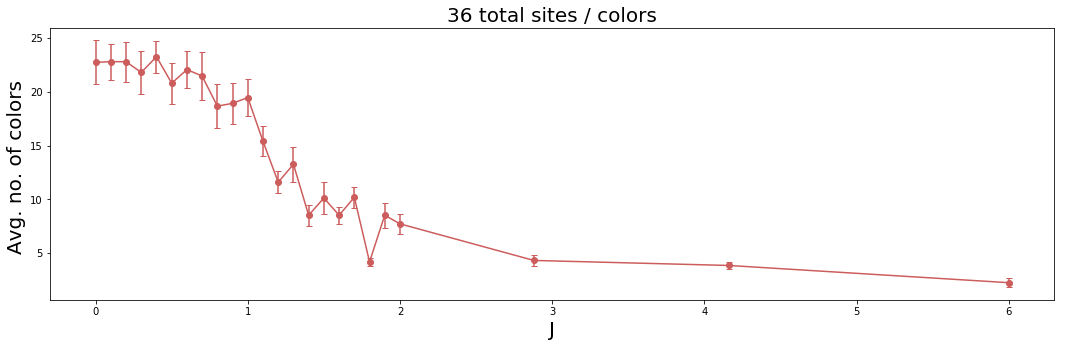

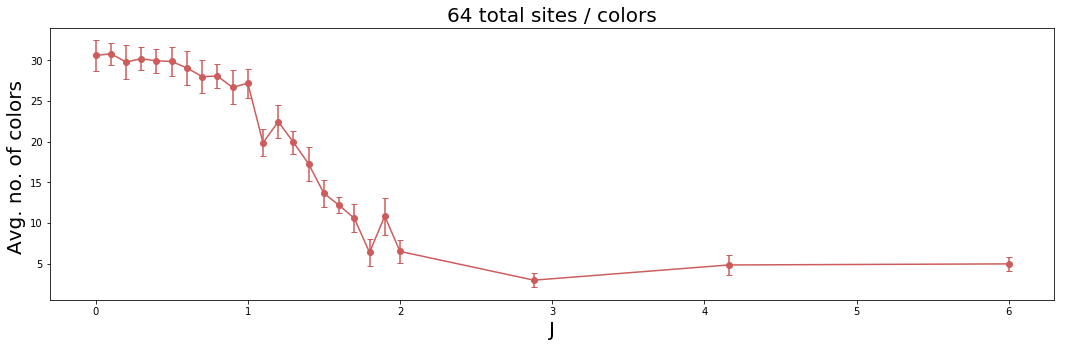

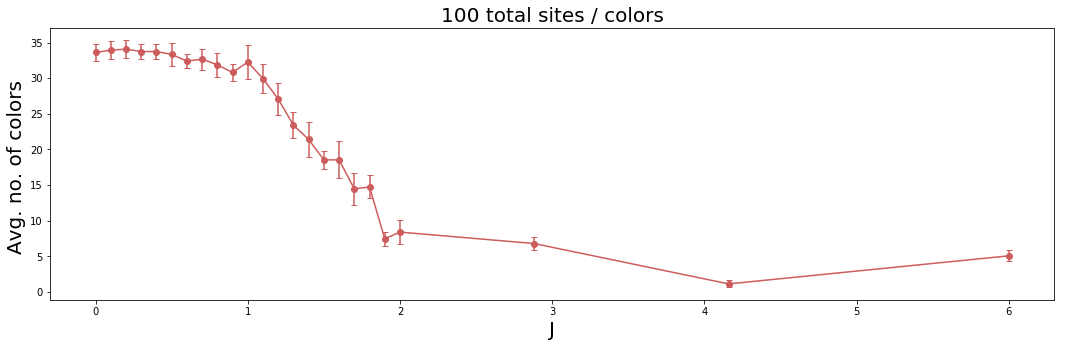

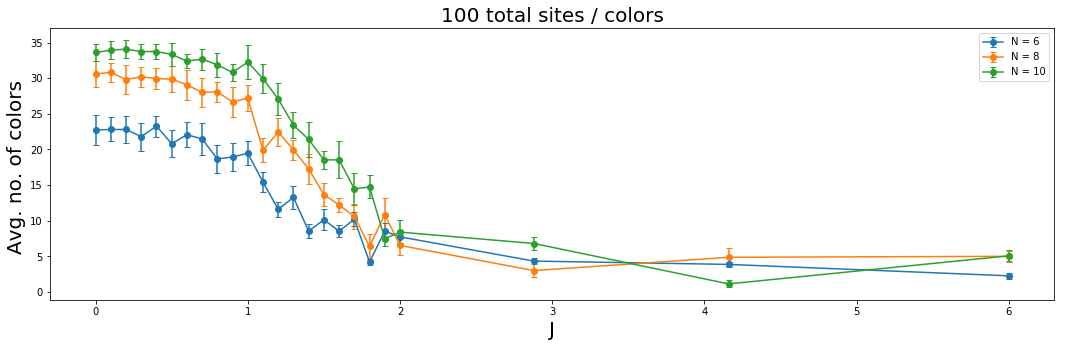

In [29]:
eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
nN = 3
params, avg_c, std_c = [], [], []
Ns = [6,8,10]
for N in Ns:
    print("N:",N,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, 36, Js=Js, gamma=0, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Ns, "J", "N", save_opts="5")

## Gamma (lambda / total number of colors) with multiple J

J: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[16  9  9  3]
 [14  5  3 15]
 [13 16  3 11]
 [ 8 15 16  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 1.6
101 num. cols: 10.415841584158416 avg. sites per col: 1.5589629292599576
201 num. cols: 10.348258706467663 avg. sites per col: 1.5703820778447646
301 num. cols: 10.299003322259136 avg. sites per col: 1.5782332101268968
401 num

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 2.6666666666666665
101 num. cols: 6.455445544554456 avg. sites per col: 2.5201320132013167
201 num. cols: 6.54228855721393 avg. sites per col: 2.5068309247413736
301 num. cols: 6.73421926910299 avg. sites per col: 2.4341507145493892
401 num. cols: 6.892768079800499 avg. sites per col: 2.3821571612095376
501 num. cols: 7.083832335329341 avg. sites per col: 2.317524834890108
601 num. cols: 7.13477537437604 avg. sites per col: 2.2999349328800243
701 num. cols: 7.1797432239657635 avg. sites per col: 2.2865212137680015
801 num. cols: 7.2796504369538075 avg. sites per col: 2.254880533532215
901 num. cols: 7.227524972253052 avg. sites per col: 2.2700638860461257
1001 num. cols: 7.242757242757243 avg. sites per col: 2.2630898682846667
Final configuration:
[[14 15 15  5]
 [13 13  6 15]
 [ 6  8 11  5]
 [11  6  8  6]]
Final averages: 7.2

301 num. cols: 4.764119601328904 avg. sites per col: 3.432494858408492
401 num. cols: 4.5735660847880295 avg. sites per col: 3.5740173376083693
501 num. cols: 4.602794411177645 avg. sites per col: 3.5595095523239366
601 num. cols: 4.577371048252912 avg. sites per col: 3.599524601854074
701 num. cols: 4.355206847360913 avg. sites per col: 3.843054140343766
801 num. cols: 4.404494382022472 avg. sites per col: 3.7877415135842276
901 num. cols: 4.5049944506104325 avg. sites per col: 3.7041593996088964
1001 num. cols: 4.534465534465535 avg. sites per col: 3.6740402454688024
Final configuration:
[[13  7 15 13]
 [15  6 10 15]
 [13  6 15  7]
 [10 10 13  6]]
Final averages: 4.536318407960199 3.672153518123652
Final stds: 0.8729912995351857 0.7755201031044993
------------------------------------------------------------------------------------------------------------------------

11  - param: 4.71
lambda probabilities: [9.90995222e-01 8.92369156e-03 8.03558577e-05 7.23586626e-07
 6.51573663e-09 5

901 num. cols: 3.4761376248612654 avg. sites per col: 4.698483166851646
1001 num. cols: 3.4285714285714284 avg. sites per col: 4.761904761904732
Final configuration:
[[15  5  6  6]
 [ 6  5 15 15]
 [ 6  6  5  5]
 [ 6  5 15  6]]
Final averages: 3.426865671641791 4.76417910447758
Final stds: 0.4946224519930263 0.6594966026573683
------------------------------------------------------------------------------------------------------------------------

16  - param: 8.88
lambda probabilities: [9.99860856e-01 1.39124804e-04 1.93584048e-08 2.69360909e-12
 3.74799989e-16 5.21512317e-20 7.25653961e-24 1.00970515e-27
 1.40494580e-31 1.95490012e-35 2.72012945e-39 3.78490143e-43
 5.26646952e-47 7.32798506e-51 1.01964637e-54 1.41897587e-58]
Initial configuration
[[12 13  8  2]
 [14  3  8 14]
 [12 12  6 12]
 [ 4 12  3  4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col

401 num. cols: 8.551122194513717 avg. sites per col: 1.9235389160576286
501 num. cols: 8.50499001996008 avg. sites per col: 1.9345078961845554
601 num. cols: 8.490848585690516 avg. sites per col: 1.9368959382270634
701 num. cols: 8.514978601997147 avg. sites per col: 1.931611200655432
801 num. cols: 8.556803995006241 avg. sites per col: 1.9225823420580044
901 num. cols: 8.55493895671476 avg. sites per col: 1.9228774185489004
1001 num. cols: 8.535464535464536 avg. sites per col: 1.926346669203817
Final configuration:
[[14 14  2  9]
 [ 5 12 16  4]
 [15 12 10  9]
 [15  4 12  4]]
Final averages: 8.532338308457712 1.9269872857932608
Final stds: 1.3553648716484543 0.33532300764972856
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.86
lambda probabilities: [5.76837918e-01 2.44095934e-01 1.03292144e-01 4.37093187e-02
 1.84961263e-02 7.82685933e-03 3.31203009e-03 1.40152555e-03
 5.93072470e-04 2.50965781e-04

801 num. cols: 4.764044943820225 avg. sites per col: 3.6239938172522566
901 num. cols: 4.723640399556049 avg. sites per col: 3.6534644046297795
1001 num. cols: 4.853146853146853 avg. sites per col: 3.5584035012606337
Final configuration:
[[ 9  4  8  8]
 [ 4 11  9  8]
 [ 8  8  9  2]
 [ 8 11 11  9]]
Final averages: 4.853731343283582 3.556977019663576
Final stds: 1.2263680582886742 1.0975432184830323
------------------------------------------------------------------------------------------------------------------------

7  - param: 3.0
lambda probabilities: [9.50212932e-01 4.73083162e-02 2.35534237e-03 1.17265592e-04
 5.83831003e-06 2.90672341e-07 1.44717237e-08 7.20504697e-10
 3.58718166e-11 1.78595259e-12 8.89173435e-14 4.42693386e-15
 2.20404059e-16 1.09732719e-17 5.46327041e-19 2.86251858e-20]
Initial configuration
[[ 8  7 15 11]
 [10  7  1 13]
 [ 5  4 11 13]
 [ 8 14 12  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 5.333333333333333
101 num. cols: 2.1683168316831685 avg. sites per col: 7.551155115511551
201 num. cols: 1.8208955223880596 avg. sites per col: 9.883913764510778
301 num. cols: 1.6677740863787376 avg. sites per col: 10.959025470653376
401 num. cols: 1.5012468827930174 avg. sites per col: 12.216126350789692
501 num. cols: 1.620758483033932 avg. sites per col: 11.725881570192918
601 num. cols: 1.8236272878535773 avg. sites per col: 10.73322240709921
701 num. cols: 1.7803138373751783 avg. sites per col: 10.891107941036557
801 num. cols: 1.8626716604244695 avg. sites per col: 10.383687057844321
901 num. cols: 1.9855715871254163 avg. sites per col: 9.832038475767694
1001 num. cols: 2.008991008991009 avg. sites per col: 9.649017649017695
Final configuration:
[[3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
Final averages: 2.004975124378

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-001 1.12535162e-007 1.26641641e-014 1.42516392e-021
 1.60381071e-028 1.80485118e-035 2.03109243e-042 2.28569342e-049
 2.57220908e-0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 2.287128712871287 avg. sites per col: 10.178217821782187
201 num. cols: 2.487562189054726 avg. sites per col: 8.311774461028186
301 num. cols: 2.0996677740863787 avg. sites per col: 10.033222591362122
401 num. cols: 2.14214463840399 avg. sites per col: 9.559434746467172
501 num. cols: 2.2135728542914173 avg. sites per col: 9.279041916167657
601 num. cols: 2.0515806988352745 avg. sites per col: 10.077870216306149
701 num. cols: 2.108416547788873 avg. sites per col: 9.857536852116011
801 num. cols: 1.9700374531835205 avg. sites per col: 10.624386183936734
901 num. cols: 1.9311875693673697 avg. sites per col: 10.777062523122458
1001 num. cols: 1.901098901098901 avg. sites per col: 10.853946053946057
Final configuration:
[[13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]
 [13  5 13 13]]
Final averages: 1.902487562189

401 num. cols: 1.399002493765586 avg. sites per col: 12.807980049875312
501 num. cols: 1.3632734530938124 avg. sites per col: 13.0938123752495
601 num. cols: 1.302828618968386 avg. sites per col: 13.577371048252912
701 num. cols: 1.2596291012838803 avg. sites per col: 13.922967189728958
801 num. cols: 1.227215980024969 avg. sites per col: 14.182272159800249
901 num. cols: 1.2097669256381798 avg. sites per col: 14.321864594894562
1001 num. cols: 1.1888111888111887 avg. sites per col: 14.48951048951049
Final configuration:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Final averages: 1.1880597014925374 14.495522388059701
Final stds: 0.3907598369421748 3.1260786955373985
------------------------------------------------------------------------------------------------------------------------

10  - param: 4.29
lambda probabilities: [9.86295075e-01 1.35171003e-02 1.85250850e-04 2.53884906e-06
 3.47947367e-08 4.76859268e-10 6.53532064e-12 8.95660812e-14
 1.22749645e-15 1.68227472e-17 2.3055449

801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 8.88
lambda probabilities: [9.99860856e-01 1.39124804e-04 1.93584048e-08 2.69360909e-12
 3.74799989e-16 5.21512317e-20 7.25653961e-24 1.00970515e-27
 1.40494580e-31 1.95490012e-35 2.72012945e-39 3.78490143e-43
 5.26646952e-47 7.32798506e-51 1.01964637e-54 1.41897587e-58]
Initial configuration
[[ 1  1  9  8]
 [ 2 14 13 11]
 [ 8 12  5 16]
 [12  9 14 13]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.

901 num. cols: 3.0832408435072143 avg. sites per col: 7.567366065923201
1001 num. cols: 2.937062937062937 avg. sites per col: 8.020842649414053
Final configuration:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
Final averages: 2.9293532338308457 8.05260048961539
Final stds: 1.7039562042120175 5.1110401712642926
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.86
lambda probabilities: [5.76837918e-01 2.44095934e-01 1.03292144e-01 4.37093187e-02
 1.84961263e-02 7.82685933e-03 3.31203009e-03 1.40152555e-03
 5.93072470e-04 2.50965781e-04 1.06199203e-04 4.49394757e-05
 1.90166821e-05 8.04713881e-06 3.40524402e-06 2.49805033e-06]
Initial configuration
[[ 7 15 15  8]
 [15 10  6  8]
 [14  5  7  7]
 [ 9 12 14  1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. co

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.2475247524752475 avg. sites per col: 14.01980198019802
201 num. cols: 1.1840796019900497 avg. sites per col: 14.527363184079602
301 num. cols: 1.1295681063122924 avg. sites per col: 14.96345514950166
401 num. cols: 1.0972568578553616 avg. sites per col: 15.221945137157107
501 num. cols: 1.0778443113772456 avg. sites per col: 15.377245508982035
601 num. cols: 1.064891846921797 avg. sites per col: 15.480865224625624
701 num. cols: 1.0570613409415122 avg. sites per col: 15.543509272467903
801 num. cols: 1.0499375780274656 avg. sites per col: 15.600499375780275
901 num. cols: 1.0688124306326303 avg. sites per col: 15.449500554938957
1001 num. cols: 1.0739260739260739 avg. sites per col: 15.408591408591409
Final configuration:
[[11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]]
Final averages: 1.07363

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

14  - param: 6.0
lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14 2.31377331e-16 5.73527062e-1

J: 1.1 ####################################################################################################
edge probabilities: [0.88919684 0.11080316]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[ 5 14  6  3]
 [ 4  9  9  1]
 [14  5  2 14]
 [16  7  1  2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 4.8316831683168315 avg. sites per col: 3.593587930221594
201 num. cols: 4.442786069651741 avg. sites per col: 4.318313195925141
301 num. cols: 3.5913621262458473 avg. sites per co

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.099009900990099 avg. sites per col: 15.207920792079207
201 num. cols: 1.0497512437810945 avg. sites per col: 15.601990049751244
301 num. cols: 1.0332225913621262 avg. sites per col: 15.73421926910299
401 num. cols: 1.0648379052369077 avg. sites per col: 15.481296758104738
501 num. cols: 1.1057884231536925 avg. sites per col: 15.15369261477046
601 num. cols: 1.0881863560732112 avg. sites per col: 15.29450915141431
701 num. cols: 1.1112696148359487 avg. sites per col: 15.132667617689018
801 num. cols: 1.097378277153558 avg. sites per col: 15.240948813982524
901 num. cols: 1.0865704772475027 avg. sites per col: 15.325194228634853
1001 num. cols: 1.0909090909090908 avg. sites per col: 15.310023310023315
Final configuration:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Final averages: 1.090547263681592 15.3127

801 num. cols: 1.048689138576779 avg. sites per col: 15.610486891385769
901 num. cols: 1.0432852386237514 avg. sites per col: 15.653718091009988
1001 num. cols: 1.0389610389610389 avg. sites per col: 15.688311688311689
Final configuration:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
Final averages: 1.0388059701492538 15.68955223880597
Final stds: 0.19313225217458876 1.5450580173967101
------------------------------------------------------------------------------------------------------------------------

11  - param: 4.71
lambda probabilities: [9.90995222e-01 8.92369156e-03 8.03558577e-05 7.23586626e-07
 6.51573663e-09 5.86727592e-11 5.28335146e-13 4.75754048e-15
 4.28405939e-17 3.85770019e-19 3.47377322e-21 3.12805552e-23
 2.81674443e-25 2.53641571e-27 2.28398593e-29 2.07536675e-31]
Initial configuration
[[ 5  9 14 11]
 [11  3  2 16]
 [16 11 12  9]
 [ 9 16  6  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

18  - param: 13.15
lambda probabilities: [9.99998055e-01 1.94547977e-06 3.78489888e-12 7.36345851e-18
 1.43254874e-23 2.78700001e-29 5.42206267e-35 1.05485337e

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 1.3564356435643565 avg. sites per col: 13.201320132013203
201 num. cols: 1.1791044776119404 avg. sites per col: 14.593698175787729
301 num. cols: 1.1196013289036544 avg. sites per col: 15.0609080841639
401 num. cols: 1.0897755610972568 avg. sites per col: 15.295095594347465
501 num. cols: 1.0718562874251496 avg. sites per col: 15.43579507651364
601 num. cols: 1.0698835274542429 avg. sites per col: 15.449805879090405
701 num. cols: 1.0599144079885878 avg. sites per col: 15.528292914883501
801 num. cols: 1.0549313358302121 avg. sites per col: 15.567207657095299
901 num. cols: 1.0932297447280799 avg. sites per col: 15.260081391046986
1001 num. cols: 1.1788211788211789 avg. sites per col: 14.779620379620388
Final configuration:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 1.1781094527363185 14.78

1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 3.86
lambda probabilities: [9.78932000e-01 2.06241389e-02 4.34509349e-04 9.15424276e-06
 1.92861582e-07 4.06320772e-09 8.56036583e-11 1.80349783e-12
 3.79960915e-14 8.00501637e-16 1.68649681e-17 3.55311140e-19
 7.48569492e-21 1.57708617e-22 3.32260507e-24 7.15071547e-26]
Initial configuration
[[16  1  9 16]
 [13 16  7  9]
 [ 2  6  7  3]
 [ 6 12 14 11]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0232558139534884 avg. sites per col: 15.81395

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0518962075848304 avg. sites per col: 15.584830339321357
601 num. cols: 1.043261231281198 avg. sites per col: 15.653910149750416
701 num. cols: 1.037089871611983 avg. sites per col: 15.703281027104136
801 num. cols: 1.0324594257178528 avg. sites per col: 15.740324594257178
901 num. cols: 1.0288568257491675 avg. sites per col: 15.76914539400666
1001 num. cols: 1.025974025974026 avg. sites per col: 15.792207792207792
Final configuration:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 1.0258706467661691 15.793034825870647
Final stds: 0.1587493508713319 1.2699948069706553
----------------------------------------------------

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.054862842892768 avg. sites per col: 15.561097256857856
501 num. cols: 1.1317365269461077 avg. sites per col: 14.946107784431138
601 num. cols: 1.1680532445923462 avg. sites per col: 14.65557404326123
701 num. cols: 1.1626248216833095 avg. sites per col: 14.699001426533524
801 num. cols: 1.202247191011236 avg. sites per col: 14.382022471910112
901 num. cols: 1.1798002219755828 avg. sites per col: 14.561598224195338
1001 num. cols: 1.1658341658341658 avg. sites per col: 14.673326673326674
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 1.1651741293532338 14.67860696517413
Final stds: 0.3713376312005491 2.9707010496043926
---------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[12 12 12 12]
 [12 12 12 12]
 [12 12 12 12]
 [12 12 12 12]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 3.43
lambda probabilities: [9.67613059e-01 3.13380268e-02 1.01494282e-03 3.28708930e-05
 1.06458766e-06 3.44787376e-08 1.11666083e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 7.3
lambda probabilities: [9.99324461e-01 6.75082423e-04 4.56044353e-07 3.08075644e-10
 2.08117043e-13 1.40591132e-16 9.49747613e-

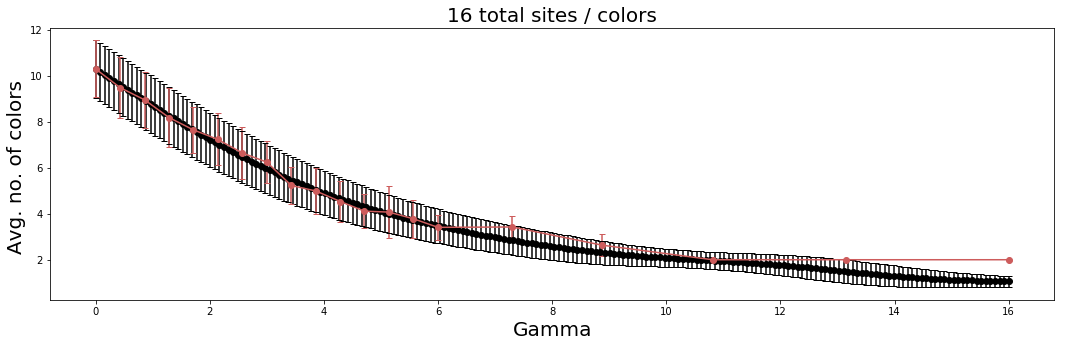

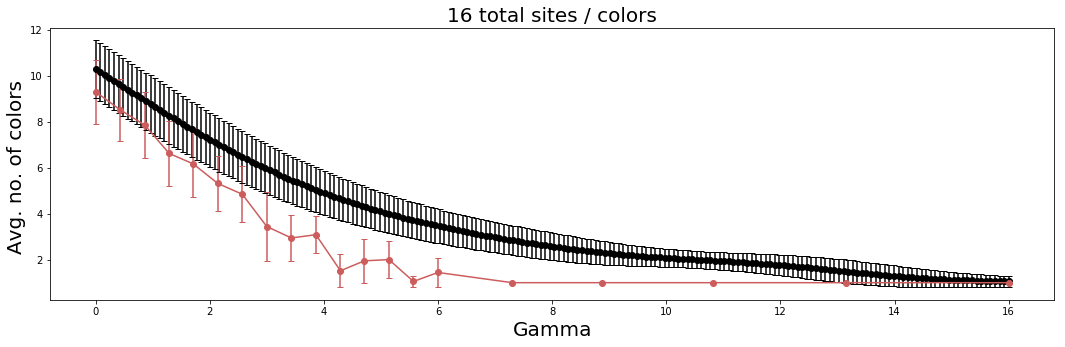

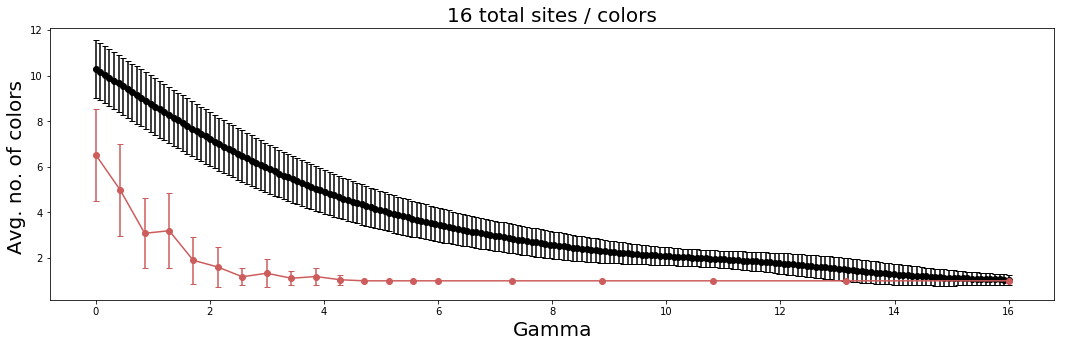

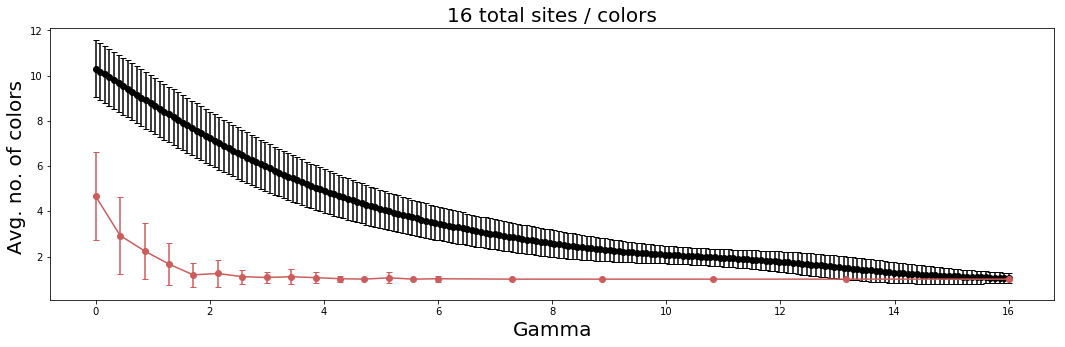

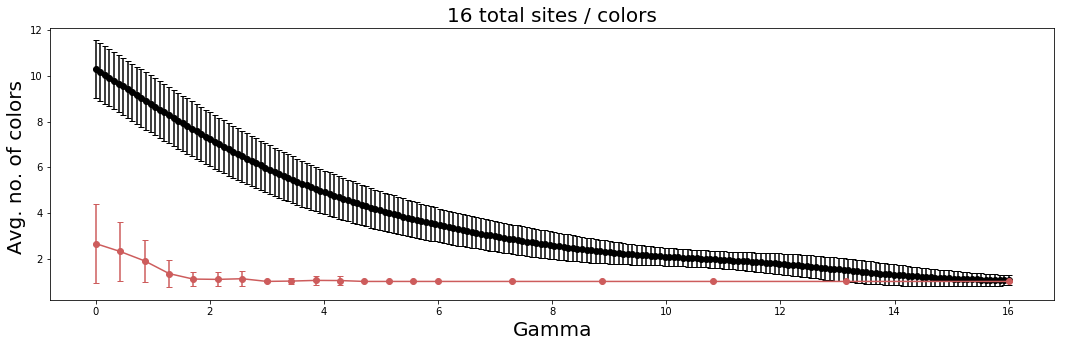

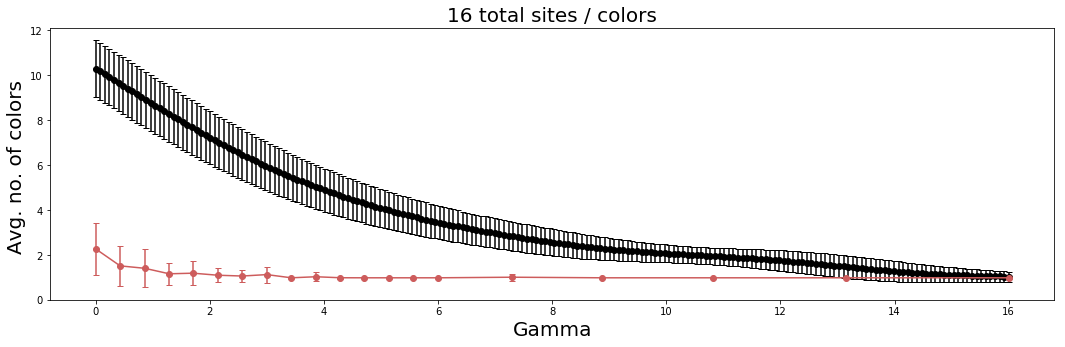

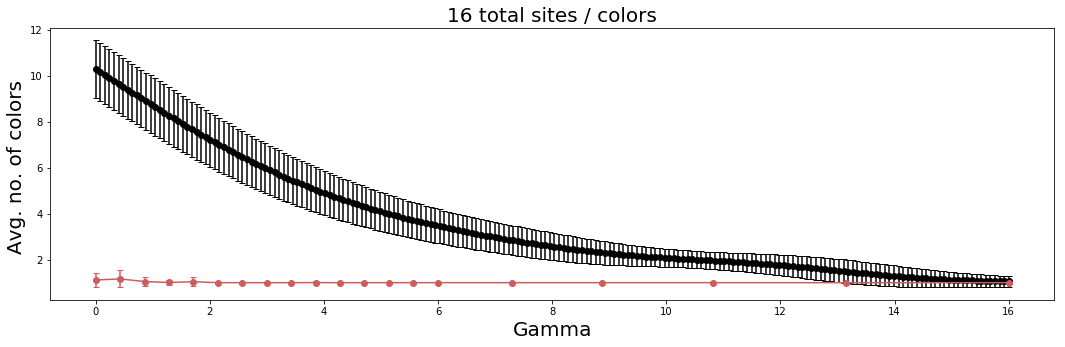

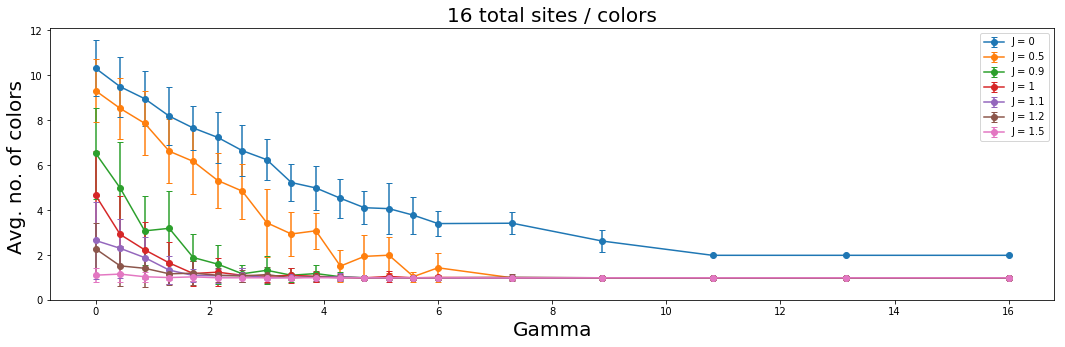

In [47]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
N = 4

nJ = 7
params, avg_c, std_c = [], [], []
Js = [0,0.5,0.9,1,1.1,1.2,1.5]
for J in Js:
    print("J:",J,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, J=J, gammas=gammas, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Js, "Gamma", "J")

J: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[11 11 12  1  8]
 [15 21  3 20  7]
 [25 14 21  6 16]
 [ 5 24 25 10 23]
 [19  2 15 25  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 1.6666666666666667
101 num. cols: 15.92079207920792 avg. sites per col: 1.5852932095594474
201 num. cols: 16.0298507

301 num. cols: 11.953488372093023 avg. sites per col: 2.1275187990304216
401 num. cols: 11.778054862842893 avg. sites per col: 2.1595855308448795
501 num. cols: 11.962075848303392 avg. sites per col: 2.126612368004583
601 num. cols: 11.918469217970049 avg. sites per col: 2.138599348977882
701 num. cols: 12.108416547788874 avg. sites per col: 2.104854315823932
801 num. cols: 12.123595505617978 avg. sites per col: 2.1005238560041284
901 num. cols: 12.077691453940066 avg. sites per col: 2.10661291531402
1001 num. cols: 12.003996003996004 avg. sites per col: 2.1179071128019165
Final configuration:
[[16  5 12  2  2]
 [13 22  2  2  2]
 [ 2 11  8 22 23]
 [ 2  2 16  5  2]
 [11 21  8  5 21]]
Final averages: 11.997014925373135 2.1192017384949713
Final stds: 1.5648473753804057 0.2750077888945496
------------------------------------------------------------------------------------------------------------------------

5  - param: 2.14
lambda probabilities: [8.82345157e-01 1.03812181e-01 1.22140059e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 6.801980198019802 avg. sites per col: 3.7078618576143367
201 num. cols: 5.9054726368159205 avg. sites per col: 4.350716654821134
301 num. cols: 6.401993355481728 avg. sites per col: 4.038720139218489
401 num. cols: 6.800498753117207 avg. sites per col: 3.8111071527530465
501 num. cols: 7.111776447105789 avg. sites per col: 3.651150080790807
601 num. cols: 7.425956738768718 avg. sites per col: 3.5082567414098302
701 num. cols: 7.540656205420827 avg. sites per col: 3.4506402418314
801 num. cols: 7.355805243445693 avg. sites per col: 3.5400318054812305
901 num. cols: 7.165371809100999 avg. sites per col: 3.6428769621055745
1001 num. cols: 7.193806193806194 avg. sites per col: 3.617503528217786
Final configuration:
[[11 13 11 13 12]
 [11  5 22 17 22]
 [17 15  9 12 12]
 [ 9 15 13 13  5]
 [13  9 20 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 5.0 avg. sites per col: 5.0
201 num. cols: 5.0 avg. sites per col: 5.0
301 num. cols: 5.0 avg. sites per col: 5.0
401 num. cols: 5.0 avg. sites per col: 5.0
501 num. cols: 5.16566866267465 avg. sites per col: 4.861942781104433
601 num. cols: 5.166389351081531 avg. sites per col: 4.861342207432032
701 num. cols: 5.285306704707561 avg. sites per col: 4.762244412743656
801 num. cols: 5.3745318352059925 avg. sites per col: 4.687890137328282
901 num. cols: 5.443951165371809 avg. sites per col: 4.630040695523435
1001 num. cols: 5.4995004995005 avg. sites per col: 4.583749583749562
Final configuration:
[[25 11 18 14 11]
 [14 14 11 14 21]
 [12 12 21 25 14]
 [14 11 18 25 21]
 [18 14 12 14 12]]
Final averages: 5.501492537313433 4.582089552238785
Final stds: 0.49999777232740555 0.4166648102728378
----------------------

301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[25  1 25  1 20]
 [ 1 12 12 12  1]
 [20  1 20 25 12]
 [20 20  1 25 25]
 [12 25 20  1 25]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

J: 0.5 ####################################################################################################
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 2.272727272727273
101 num. cols: 11.267326732673267 avg. sites per col: 2.2614782082603875
201 num. cols: 10.034825870646767 avg. sites per col: 2.557384572309944
301 num. cols: 9.794019933554818 avg. sites per col: 2.618057468555809
401 num. cols: 9.967581047381547 avg. sites per col: 2.569589422768977
501 num. cols: 9.950099800399201 avg. sites per col: 2.5672496443454573
601 num. cols: 10.164725457570716 avg. sites per col: 2.5175765951556306
701 num. cols: 10.118402282453637 avg. sites per col: 2.5285478905307732
801 num. cols: 10.106117353308365 avg. sites per col: 2.529479987345157
901 num. cols: 10.114317425083241 avg. sites per col: 2.5277447918957434
1001 num. cols: 10.12987012987013 avg. sites per col: 2.5222022399844755
Final configuration:
[[ 4  4 11  8  1]
 [ 8  4 16  2  7]
 [ 8  4 12 12  7]
 [12  4  4  4 11]
 [ 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 7.0495049504950495 avg. sites per col: 3.5714285714285765
201 num. cols: 6.746268656716418 avg. sites per col: 3.806463713180134
301 num. cols: 6.076411960132891 avg. sites per col: 4.327572114116966
401 num. cols: 6.027431421446384 avg. sites per col: 4.327227566005635
501 num. cols: 6.079840319361278 avg. sites per col: 4.260724582580888
601 num. cols: 6.311148086522462 avg. sites per col: 4.11136861844017
701 num. cols: 6.433666191155492 avg. sites per col: 4.027975907433816
801 num. cols: 6.384519350811486 avg. sites per col: 4.045290608960997
901 num. cols: 6.150943396226415 avg. sites per col: 4.276112960907615
1001 num. cols: 5.802197802197802 avg. sites per col: 4.822954822954792
Final configuration:
[[ 9  9  9 24 24]
 [ 9  9  9  9 12]
 [ 9  9  9 12 12]
 [ 9  9 24 12 24]
 [24 24 24 24 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.0 avg. sites per col: 12.5
201 num. cols: 2.0 avg. sites per col: 12.5
301 num. cols: 2.0 avg. sites per col: 12.5
401 num. cols: 1.827930174563591 avg. sites per col: 14.650872817955113
501 num. cols: 1.8622754491017963 avg. sites per col: 14.221556886227544
601 num. cols: 1.8851913477537439 avg. sites per col: 13.935108153078202
701 num. cols: 1.9015691868758915 avg. sites per col: 13.730385164051356
801 num. cols: 1.9138576779026217 avg. sites per col: 13.576779026217228
901 num. cols: 1.923418423973363 avg. sites per col: 13.457269700332963
1001 num. cols: 1.931068931068931 avg. sites per col: 13.361638361638361
Final configuration:
[[11 20 20 11 20]
 [20 20 20 20 20]
 [20 20 20 20 11]
 [20 20 20 20 20]
 [20 20 20 20 20]]
Final averages: 1.9313432835820896 13.35820895522388
Final stds: 0.2528694756363

J: 0.9 ####################################################################################################
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[15  9 15  4  8]
 [17  5 16 14 25]
 [ 8 18 16 21 15]
 [15 12 15 15 17]
 [15 19 11 15  8]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 12.0 avg. sites per col: 2.0833333333333335
101 num. cols: 12.306930693069306 avg. sites per col: 2.072011802828635
201 num

301 num. cols: 3.777408637873754 avg. sites per col: 8.934009650371774
401 num. cols: 3.5635910224438905 avg. sites per col: 9.64768139175871
501 num. cols: 3.2614770459081837 avg. sites per col: 10.424923961600614
601 num. cols: 3.2712146422628954 avg. sites per col: 10.07551897630931
701 num. cols: 3.8716119828815976 avg. sites per col: 9.145127142630683
801 num. cols: 3.7228464419475658 avg. sites per col: 9.802206567187818
901 num. cols: 3.4661487236403996 avg. sites per col: 10.966408576009004
1001 num. cols: 3.4605394605394606 avg. sites per col: 10.68130282415997
Final configuration:
[[20 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 3.454726368159204 10.688541419884706
Final stds: 2.0926761770140248 7.046377715170249
------------------------------------------------------------------------------------------------------------------------

5  - param: 2.14
lambda probabilities: [8.82345157e-01 1.03812181e-01 1.22140059e-02 1.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.108910891089109 avg. sites per col: 23.638613861386137
201 num. cols: 1.1144278606965174 avg. sites per col: 23.569651741293534
301 num. cols: 1.1627906976744187 avg. sites per col: 22.96511627906977
401 num. cols: 1.1221945137157108 avg. sites per col: 23.472568578553616
501 num. cols: 1.1017964071856288 avg. sites per col: 23.727544910179642
601 num. cols: 1.1663893510815309 avg. sites per col: 23.128119800332794
701 num. cols: 1.1654778887303852 avg. sites per col: 23.133618640038055
801 num. cols: 1.1448189762796503 avg. sites per col: 23.366625052018325
901 num. cols: 1.1287458379578246 avg. sites per col: 23.54790972992972
1001 num. cols: 1.1258741258741258 avg. sites per col: 23.56809856809858
Final configuration:
[[21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21

equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 7.3
lambda probabilities: [9.99324461e-01 6.75082423e-04 4.56044353e-07 3.08075644e-10
 2.08117043e-13 1.40591132e-16 9.49747613e-20 6.41591339e-23
 4.33419827e-26 2.92791899e-29 1.97792281e-32 1.3361

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 12.0 avg. sites per col: 2.0833333333333335
101 num. cols: 12.148514851485148 avg. sites per col: 2.0961278820189717
201 num. cols: 11.472636815920398 avg. sites per col: 2.244371334856408
301 num. cols: 11.435215946843854 avg. sites per col: 2.2561727908488707
401 num. cols: 11.059850374064839 avg. sites per col: 2.378633679288293
501 num. cols: 11.05189620758483 avg. sites per col: 2.3701666347624424
601 num. cols: 11.221297836938437 avg. sites per col: 2.3305245719175898
701 num. cols: 10.620542082738945 avg. sites per col: 2.5642152018075084
801 num. cols: 10.705368289637953 avg. sites per col: 2.5291679421856768
901 num. cols: 10.899001109877913 avg. sites per col: 2.4754483975651724
1001 num. cols: 11.03096903096903 avg. sites per col: 2.4361167641784265
Final configuration:
[[10 10  1 20  2]
 [10 15 20 20 20]
 [16  8 20 20 20]
 [10 10 23 23 23

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.772277227722772 avg. sites per col: 12.830033003300331
201 num. cols: 1.9601990049751243 avg. sites per col: 18.014096185737976
301 num. cols: 1.8106312292358804 avg. sites per col: 18.43853820598006
401 num. cols: 1.6084788029925188 avg. sites per col: 20.074812967581042
501 num. cols: 1.5508982035928143 avg. sites per col: 20.259481037924147
601 num. cols: 1.459234608985025 avg. sites per col: 21.04825291181364
701 num. cols: 1.4079885877318117 avg. sites per col: 21.43366619115549
801 num. cols: 1.4332084893882646 avg. sites per col: 20.937369954223886
901 num. cols: 1.390677025527192 avg. sites per col: 21.31890492045875
1001 num. cols: 1.3606393606393605 avg. sites per col: 21.57425907425907
Final configuration:
[[19 19 19 19 16]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0297029702970297 avg. sites per col: 24.628712871287128
201 num. cols: 1.154228855721393 avg. sites per col: 23.072139303482587
301 num. cols: 1.106312292358804 avg. sites per col: 23.67109634551495
401 num. cols: 1.0798004987531171 avg. sites per col: 24.002493765586035
501 num. cols: 1.0638722554890219 avg. sites per col: 24.201596806387226
601 num. cols: 1.0532445923460898 avg. sites per col: 24.334442595673877
701 num. cols: 1.0456490727532097 avg. sites per col: 24.42938659058488
801 num. cols: 1.0399500624219726 avg. sites per col: 24.500624219725342
901 num. cols: 1.0355160932297447 avg. sites per col: 24.55604883462819
1001 num. cols: 1.031968031968032 avg. sites per col: 24.6003996003996
Final configuration:
[[6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]]
Final averages: 1.03184

equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 8.88
lambda probabilities: [9.99860856e-01 1.39124804e-04 1.93584048e-08 2.69360909e-12
 3.74799989e-16 5.21512317e-20 7.25653961e-24 1.00970515e-27
 1.40494580e-31 1.95490012e-35 2.72012945e-39 3.784

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.8217821782178218 avg. sites per col: 16.893564356435647
201 num. cols: 2.009950248756219 avg. sites per col: 14.919154228855733
301 num. cols: 2.8870431893687707 avg. sites per col: 12.053340716131425
401 num. cols: 3.3266832917705735 avg. sites per col: 10.628686220955549
501 num. cols: 3.1377245508982035 avg. sites per col: 10.860818046446763
601 num. cols: 3.0898502495840265 avg. sites per col: 11.055912104164987
701 num. cols: 2.951497860199715 avg. sites per col: 11.44023277404158
801 num. cols: 3.00749063670412 avg. sites per col: 10.991493767710974
901 num. cols: 2.819089900110988 avg. sites per col: 12.116189242992775
1001 num. cols: 2.8701298701298703 avg. sites per col: 12.009676831105384
Final configuration:
[[25 25  3  3 22]
 [ 3  3  3  3  3]
 [ 3  3  3  3  3]
 [ 3  6  3  3  3]
 [ 3  3  3  3  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.108910891089109 avg. sites per col: 23.638613861386137
201 num. cols: 1.318407960199005 avg. sites per col: 21.019900497512438
301 num. cols: 1.26578073089701 avg. sites per col: 21.677740863787374
401 num. cols: 1.2169576059850373 avg. sites per col: 22.288029925187033
501 num. cols: 1.1996007984031936 avg. sites per col: 22.50499001996008
601 num. cols: 1.1663893510815309 avg. sites per col: 22.920133111480865
701 num. cols: 1.1426533523537803 avg. sites per col: 23.216833095577748
801 num. cols: 1.1248439450686643 avg. sites per col: 23.4394506866417
901 num. cols: 1.1587125416204218 avg. sites per col: 23.01609322974473
1001 num. cols: 1.1428571428571428 avg. sites per col: 23.214285714285715
Final configuration:
[[21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]

201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.026973026973027 avg. sites per col: 24.662837162837164
Final configuration:
[[21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21 21]
 [21 21 21 21  3]
 [21 21 21 21 21]]
Final averages: 1.0308457711442787 24.614427860696516
Final stds: 0.172899709504653 2.161246368808163
------------------------------------------------------------------------------------------------------------------------

12  - param: 5.14
lambda probabilities: [9.94142310e-01 5.82337718e-03 3.41115366e-05 1.99814797e-07
 1.17045308e-09 6.85615098e-12 4.01612051e-14 2.35251878e-16
 1.37803250e-18 8.07208683e-21 4.72837800e-23 2.76973712e-25
 1.62242606e-27 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

18  - param: 13.15
lambda probabilities: [9.99998055e-001 1.94547977e-006 3.78489888e-012 7.36345851e-018
 1.4325

equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 2.3069306930693068 avg. sites per col: 14.554455445544551
201 num. cols: 1.6567164179104477 avg. sites per col: 19.751243781094526
301 num. cols: 1.654485049833887 avg. sites per col: 19.615171650055355
401 num. cols: 1.5261845386533666 avg. sites per col: 20.521612635078956
501 num. cols: 1.4211576846307385 avg. sites per col: 21.41550232867597
601 num. cols: 1.3510815307820299 avg. sites per col: 22.011924570160833
701 num. cols: 1.4008559201141226 avg. sites per col: 21.41583452211128
801 num. cols: 1.3770287141073658 avg. sites per col: 21.535580524344578
901 num. cols: 1.335183129855716 avg. sites per col: 21.920088790233084
1001 num. cols: 1.3026973026973028 avg. sites per col: 22.21528471528472
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [ 4 16 16 16 16]]
Final averages: 1.3054726368159204 22.176616915422894
Final stds: 0.7229155318338921 5.84213128

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0199501246882794 avg. sites per col: 24.75062344139651
501 num. cols: 1.0159680638722555 avg. sites per col: 24.800399201596807
601 num. cols: 1.0133111480865225 avg. sites per col: 24.83361064891847
701 num. cols: 1.0114122681883024 avg. sites per col: 24.85734664764622
801 num. cols: 1.0099875156054932 avg. sites per col: 24.875156054931335
901 num. cols: 1.0088790233074363 avg. sites per col: 24.889012208657046
1001 num. cols: 1.007992007992008 avg. sites per col: 24.9000999000999
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 1.0079601990049751 24.90049751243781
Final stds: 0.0888641335791685

101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[23 23 23 23 23]
 [23 23 23 23 23]
 [23 23 23 23 23]
 [23 23 23 23 23]
 [23 23 23 23 23]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 5.57
lambda probabilities: [9.96189520e-01 3.79596067e-03 1.44644339e-05 5.51164422e-08
 2.10020125e-10 8.00277575e-13 3.04944204e-15 1.16198392e-17
 4.42771700e-20 1.68717290e-22 6.42893932e-25 2.44973475e-27
 9.33466632e-30 3.55695633e-32 1.35537125e-34 5.16461563e

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-001 1.12535162e-007 1.26641641e-014 1.42516392e-021
 1.60381

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0897755610972568 avg. sites per col: 23.877805486284288
501 num. cols: 1.12375249500998 avg. sites per col: 23.45309381237525
601 num. cols: 1.1297836938435941 avg. sites per col: 23.44703272323905
701 num. cols: 1.1112696148359487 avg. sites per col: 23.668568711364724
801 num. cols: 1.205992509363296 avg. sites per col: 22.529130253849353
901 num. cols: 1.2630410654827968 avg. sites per col: 21.850721420643723
1001 num. cols: 1.2367632367632369 avg. sites per col: 22.165334665334658
Final configuration:
[[5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 1.2358208955223882 22.17661691542288
Final stds: 0.45832319058287213 5.325155468188438
----

301 num. cols: 1.1461794019933556 avg. sites per col: 23.172757475083056
401 num. cols: 1.1097256857855362 avg. sites per col: 23.628428927680797
501 num. cols: 1.0878243512974053 avg. sites per col: 23.902195608782435
601 num. cols: 1.0732113144758735 avg. sites per col: 24.08485856905158
701 num. cols: 1.0627674750356633 avg. sites per col: 24.21540656205421
801 num. cols: 1.0549313358302121 avg. sites per col: 24.313358302122346
901 num. cols: 1.048834628190899 avg. sites per col: 24.38956714761376
1001 num. cols: 1.043956043956044 avg. sites per col: 24.45054945054945
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0437810945273631 24.45273631840796
Final stds: 0.20460769850948737 2.557596231368592
------------------------------------------------------------------------------------------------------------------------

9  - param: 3.86
lambda probabilities: [9.78932000e-01 2.06241389e-02 4.34509349e-04

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 7.3
lambda probabilities: [9.99324461e-01 6.75082423e-04 4.56044353e-07 3.08075644e-10
 2.08117043e-

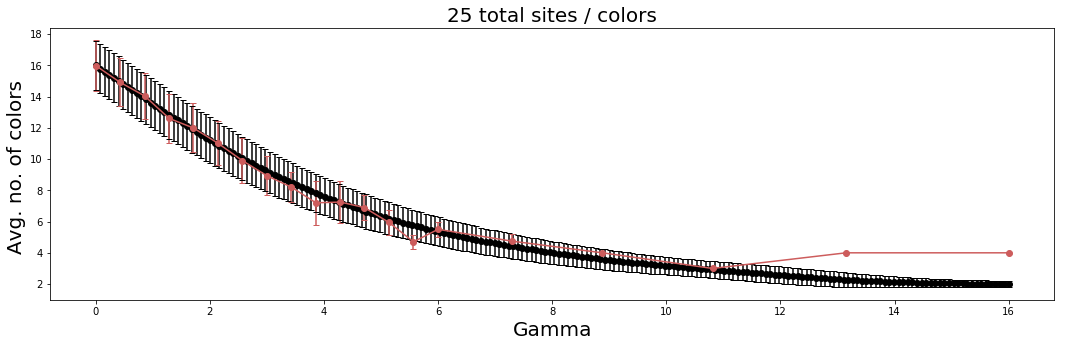

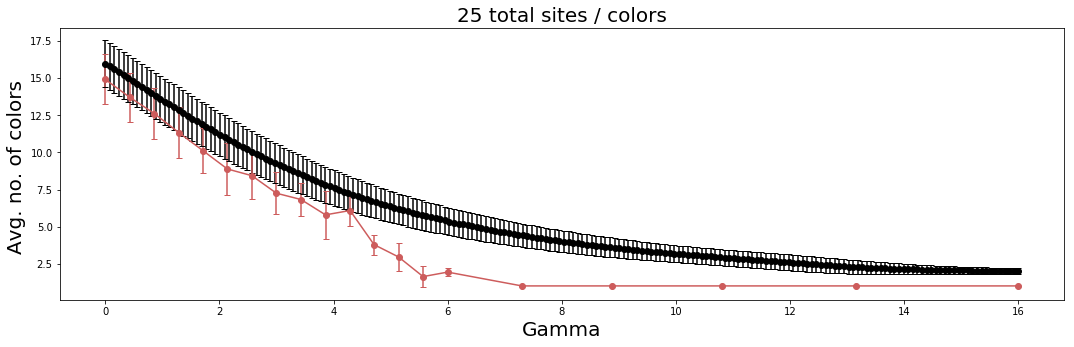

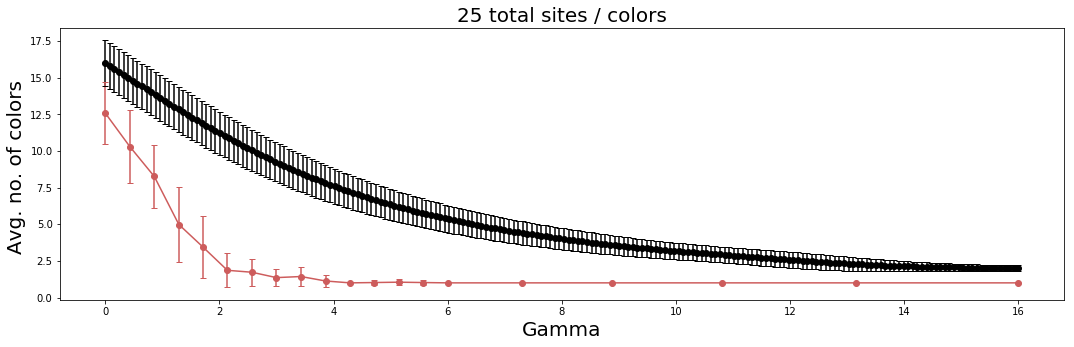

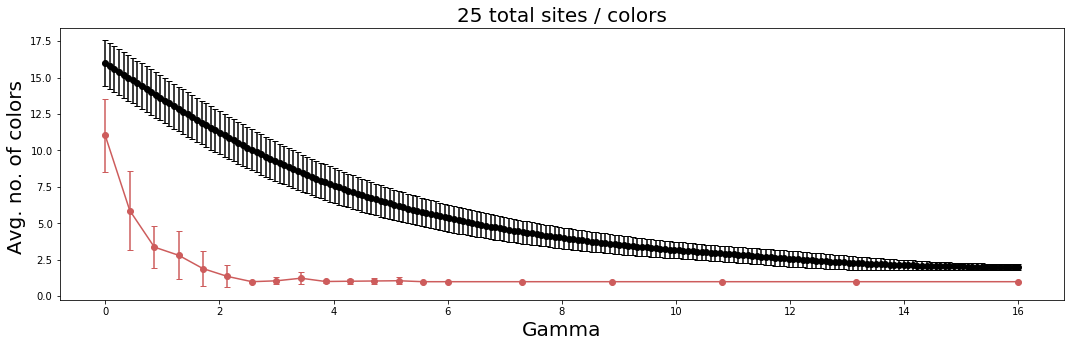

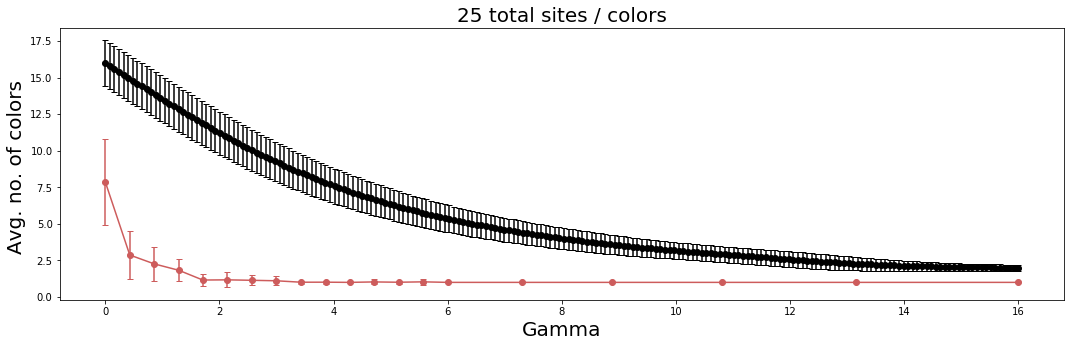

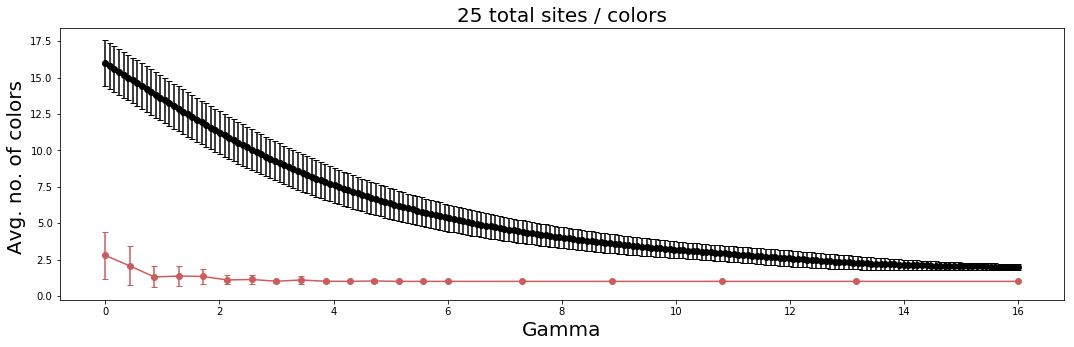

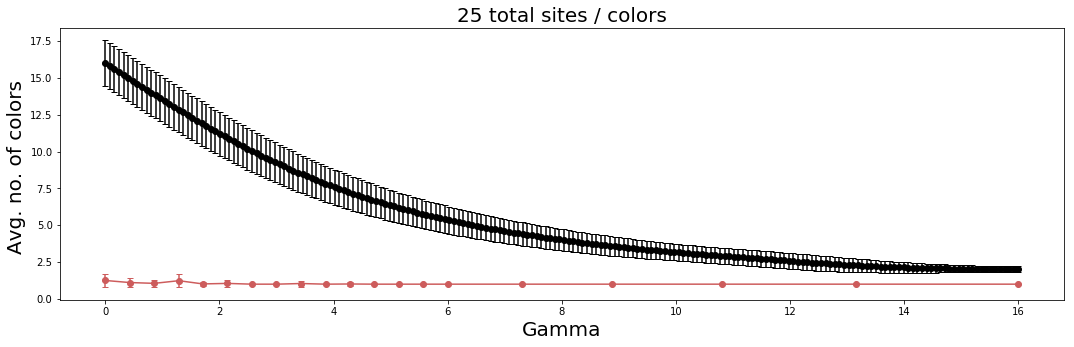

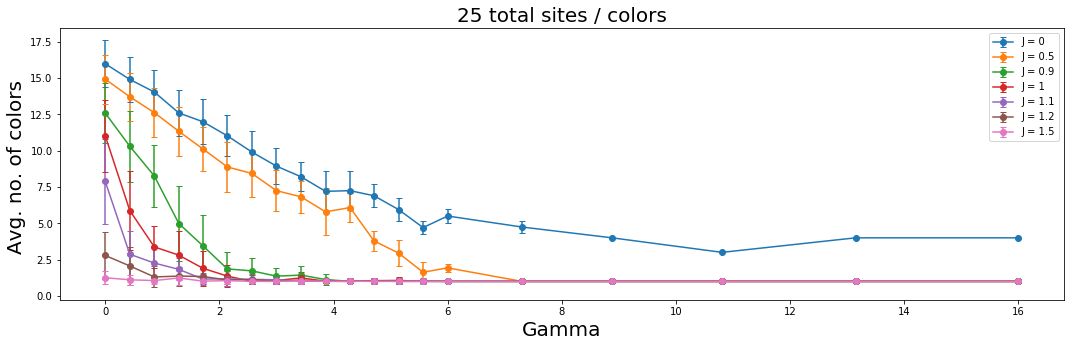

In [43]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
N = 5

nJ = 7
params, avg_c, std_c = [], [], []
Js = [0,0.5,0.9,1,1.1,1.2,1.5]
for J in Js:
    print("J:",J,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, J=J, gammas=gammas, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Js, "Gamma", "J")

J: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[ 7 12 13 16 21 19]
 [ 9 35 34 23 33 35]
 [26 35 20 15 36 21]
 [22 34 15 29 11 31]
 [15 19 14  1 34 24]
 [15 26 33  3 19 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 21.0 a

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 17.0 avg. sites per col: 2.1176470588235294
101 num. cols: 19.297029702970296 avg. sites per col: 1.878986449978575
201 num. cols: 18.572139303482587 avg. sites per col: 1.9538835959199494
301 num. cols: 18.146179401993354 avg. sites per col: 2.007390314781839
401 num. cols: 18.047381546134662 avg. sites per col: 2.02066289780268
501 num. cols: 17.489021956087825 avg. sites per col: 2.090096493068417
601 num. cols: 17.391014975041596 avg. sites per col: 2.0989655259696667
701 num. cols: 17.21540656205421 avg. sites per col: 2.1188562012470116
801 num. cols: 17.29712858926342 avg. sites per col: 2.107733926006067
901 num. cols: 17.310765815760266 avg. sites per col: 2.1058340533886337
1001 num. cols: 17.2987012987013 avg. sites per col: 2.1067303797640826
Final configuration:
[[24  3  6 29 24 22]
 [ 9 24 30 16 35 26]
 [ 9 11  4 24 16 31]
 [17 23 17  6

equilibration step: 4000
equilibration step: 5000
1 num. cols: 13.0 avg. sites per col: 2.769230769230769
101 num. cols: 12.029702970297029 avg. sites per col: 2.9989614346049995
201 num. cols: 11.91044776119403 avg. sites per col: 3.027972027972026
301 num. cols: 11.933554817275747 avg. sites per col: 3.024909973747179
401 num. cols: 12.226932668329177 avg. sites per col: 2.957811764295553
501 num. cols: 12.069860279441118 avg. sites per col: 3.0039082673813158
601 num. cols: 11.792013311148086 avg. sites per col: 3.0865434066765074
701 num. cols: 11.750356633380884 avg. sites per col: 3.093829993116724
801 num. cols: 11.777777777777779 avg. sites per col: 3.0840802144173005
901 num. cols: 11.76803551609323 avg. sites per col: 3.088366905015082
1001 num. cols: 11.796203796203796 avg. sites per col: 3.08010131726417
Final configuration:
[[32 19 36 36  3 35]
 [35  1 14 20  1  3]
 [36 19 36 16 32 35]
 [34 20 14  3  3 32]
 [32 36  3 19 23 32]
 [34 16 16 32 35 32]]
Final averages: 11.79303

101 num. cols: 8.514851485148515 avg. sites per col: 4.2514851485148535
201 num. cols: 9.253731343283581 avg. sites per col: 3.9273631840796144
301 num. cols: 9.375415282392026 avg. sites per col: 3.8722440350347385
401 num. cols: 9.69576059850374 avg. sites per col: 3.750487417819082
501 num. cols: 9.780439121756487 avg. sites per col: 3.7126111413536345
601 num. cols: 9.8369384359401 avg. sites per col: 3.687339283013128
701 num. cols: 9.860199714693294 avg. sites per col: 3.6748800414991165
801 num. cols: 9.861423220973784 avg. sites per col: 3.6720236068550225
901 num. cols: 9.76581576026637 avg. sites per col: 3.708424982342811
1001 num. cols: 9.68931068931069 avg. sites per col: 3.737553355735138
Final configuration:
[[14 17 20 17 14 32]
 [33 16 20 23 33 16]
 [17 20 20 24 16 20]
 [24 20  8 17 23 33]
 [ 8  8 23 17 20 33]
 [14 16 33 14 32 17]]
Final averages: 9.686567164179104 3.738597919493406
Final stds: 0.7318406269130019 0.29426801996391805
-------------------------------------

401 num. cols: 5.0 avg. sites per col: 7.19999999999997
501 num. cols: 5.0 avg. sites per col: 7.19999999999994
601 num. cols: 5.0 avg. sites per col: 7.199999999999919
701 num. cols: 5.0 avg. sites per col: 7.199999999999905
801 num. cols: 5.0 avg. sites per col: 7.1999999999998945
901 num. cols: 5.0 avg. sites per col: 7.199999999999886
1001 num. cols: 5.0 avg. sites per col: 7.199999999999879
Final configuration:
[[16 36  6  6  6 36]
 [36 16 31 36 36 31]
 [16 16 31 16 13 13]
 [36 36  6 36  6 13]
 [13 31 16  6 13 31]
 [ 6 13  6 16 16 31]]
Final averages: 5.0 7.1999999999998785
Final stds: 0.0 1.7763568394002505e-15
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-001 2.01961171e-005 4.07891382e-010 8.23798848e-015
 1.66378740e-019 3.36027238e-024 6.78658249e-029 1.37065383e-033
 2.76824442e-038 5.59089176e-043 1.12916585e-047 2.28052263e-052
 4.60586322e-057 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 19.0 avg. sites per col: 1.894736842105263
101 num. cols: 20.574257425742573 avg. sites per col: 1.765884721772179
201 num. cols: 20.80597014925373 avg. sites per col: 1.7447953114237127
301 num. cols: 20.774086378737543 avg. sites per col: 1.747146264017769
401 num. cols: 20.571072319201996 avg. sites per col: 1.7645314887044508
501 num. cols: 20.568862275449103 avg. sites per col: 1.765063061725178
601 num. cols: 20.608985024958404 avg. sites per col: 1.7617855981023687
701 num. cols: 20.500713266761768 avg. sites per col: 1.7733841386165021
801 num. cols: 20.541822721598002 avg. sites per col: 1.7697719514008687
901 num. cols: 20.591564927857934 avg. sites per col: 1.7651487056781598
1001 num. cols: 20.592407592407593 avg. sites per col: 1.764459204394088
Final configuration:
[[ 4 32  6 30 26 29]
 [ 4 12 26 20 28  5]
 [28 28 11  4  4  1]
 [ 8  9  

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 13.762376237623762 avg. sites per col: 2.654312955536021
201 num. cols: 12.895522388059701 avg. sites per col: 2.8279665315661755
301 num. cols: 12.840531561461795 avg. sites per col: 2.8360990973068256
401 num. cols: 13.002493765586035 avg. sites per col: 2.79944131708103
501 num. cols: 13.085828343313374 avg. sites per col: 2.7860106196492116
601 num. cols: 13.261231281198004 avg. sites per col: 2.752802688160417
701 num. cols: 13.31811697574893 avg. sites per col: 2.7371154523080348
801 num. cols: 13.435705368289637 avg. sites per col: 2.711341342802023
901 num. cols: 13.588235294117647 avg. sites per col: 2.6829937510423347
1001 num. cols: 13.475524475524475 avg. sites per col: 2.7052914588496844
Final configuration:
[[28 33 19 14 19  1]
 [14 16 33  7  7  7]
 [14 14 33 35 35 19]
 [16 14 16 16 35 16]
 [15 10  3 27  7 16]
 [16 10 16 18 33 28]]
Final aver

101 num. cols: 7.297029702970297 avg. sites per col: 5.083451202263087
201 num. cols: 8.940298507462687 avg. sites per col: 4.290101440847711
301 num. cols: 9.23920265780731 avg. sites per col: 4.095322949475774
401 num. cols: 9.042394014962593 avg. sites per col: 4.140130193995531
501 num. cols: 9.141716566866268 avg. sites per col: 4.069826580605016
601 num. cols: 9.064891846921798 avg. sites per col: 4.085828813449438
701 num. cols: 9.112696148359486 avg. sites per col: 4.050760509105719
801 num. cols: 9.088639200998752 avg. sites per col: 4.049417124698014
901 num. cols: 9.039955604883463 avg. sites per col: 4.063355290658278
1001 num. cols: 9.166833166833166 avg. sites per col: 4.008020550877691
Final configuration:
[[22 22 33  8  8 30]
 [22 22 33 35  8 24]
 [22 21 33 13 33 28]
 [22 21 35  9 21 28]
 [30 33 30 21 21 21]
 [24 33 33 12 30  9]]
Final averages: 9.17412935323383 4.005094010467143
Final stds: 1.2807520191323232 0.5986085318659065
-----------------------------------------

401 num. cols: 4.311720698254364 avg. sites per col: 8.518204488778057
501 num. cols: 4.249500998003992 avg. sites per col: 8.614371257485033
601 num. cols: 4.229617304492512 avg. sites per col: 8.639600665557403
701 num. cols: 4.329529243937232 avg. sites per col: 8.452211126961458
801 num. cols: 4.288389513108614 avg. sites per col: 8.520599250936307
901 num. cols: 4.349611542730299 avg. sites per col: 8.405993340732483
1001 num. cols: 4.463536463536464 avg. sites per col: 8.226773226773188
Final configuration:
[[12 36 36 36  9 12]
 [36 36 36 36 11 12]
 [36 36 11 36 36 36]
 [36 36 36 29 36 36]
 [ 9  9 36 36 11 29]
 [29  9 29 29 12 36]]
Final averages: 4.465671641791045 8.222686567164144
Final stds: 0.6721656331958242 1.0771820368748393
------------------------------------------------------------------------------------------------------------------------

14  - param: 6.0
lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[34 34 34 34 34 34]
 [34 34 34 34 34 34]
 [34 34 34 34 34 34]
 [34 34 34 34 34 34]
 [34 34 34 34 34 34]
 [34 34 34 34 34 34]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-001 1.12535162e-007 1.26

801 num. cols: 15.33458177278402 avg. sites per col: 2.400113940665996
901 num. cols: 15.295227524972253 avg. sites per col: 2.4050485611192167
1001 num. cols: 15.166833166833166 avg. sites per col: 2.4272777650250066
Final configuration:
[[ 1 13 36 22 17 35]
 [13 13 36 36 20 20]
 [24 22 36 36 36 16]
 [30  9 29 29 36 36]
 [ 7 36 29 29 20 10]
 [ 7 13  9 18 16 14]]
Final averages: 15.164179104477611 2.427557912567852
Final stds: 2.227353793887596 0.37151828965826894
------------------------------------------------------------------------------------------------------------------------

3  - param: 1.29
lambda probabilities: [7.24729217e-01 1.99496779e-01 5.49156346e-02 1.51166697e-02
 4.16117752e-03 1.14545059e-03 3.15309082e-04 8.67953779e-05
 2.38922316e-05 6.57683331e-06 1.81041006e-06 4.98352994e-07
 1.37182019e-07 3.77622018e-08 1.03948309e-08 2.86139323e-09
 7.87657955e-10 2.16819222e-10 5.96839970e-11 1.64292606e-11
 4.52249543e-12 1.24491086e-12 3.42687587e-13 9.43318804e-14
 2.5

1001 num. cols: 1.983016983016983 avg. sites per col: 23.99460539460539
Final configuration:
[[25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]
Final averages: 1.9791044776119402 24.042388059701487
Final stds: 1.1532179481132774 11.141242205394352
------------------------------------------------------------------------------------------------------------------------

7  - param: 3.0
lambda probabilities: [9.50212932e-01 4.73083162e-02 2.35534237e-03 1.17265592e-04
 5.83831003e-06 2.90672341e-07 1.44717237e-08 7.20504697e-10
 3.58718166e-11 1.78595259e-12 8.89173435e-14 4.42693386e-15
 2.20404059e-16 1.09732719e-17 5.46327041e-19 2.72000217e-20
 1.35420934e-21 6.74221131e-23 3.35674935e-24 1.67122709e-25
 8.32054976e-27 4.14255780e-28 2.06245808e-29 1.02683742e-30
 5.11232246e-32 2.54527548e-33 1.26721804e-34 6.30910714e-36
 3.14111948e-37 1.56387130e-38 7.78605676e-40 3.87644940e-41
 1.92997051e-42 9.60875739e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.109452736318408 avg. sites per col: 34.02985074626866
301 num. cols: 1.0730897009966778 avg. sites per col: 34.6843853820598
401 num. cols: 1.054862842892768 avg. sites per col: 35.01246882793018
501 num. cols: 1.0439121756487026 avg. sites per col: 35.209580838323355
601 num. cols: 1.0366056572379367 avg. sites per col: 35.341098169717135
701 num. cols: 1.0499286733238231 avg. sites per col: 35.10128388017118
801 num. cols: 1.1061173533083646 avg. sites per col: 34.08988764044944
901 num. cols: 1.1365149833518313 avg. sites per col: 33.542730299667035
1001 num. cols: 1.1228771228771228 avg. sites per col: 33.78821178821179
Final configuration:
[[27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-001 2.01961171e-005 4.0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 13.316831683168317 avg. sites per col: 2.769701672817574
201 num. cols: 14.840796019900498 avg. sites per col: 2.5017099577101427
301 num. cols: 15.6578073089701 avg. sites per col: 2.3730998061174673
401 num. cols: 15.179551122194514 avg. sites per col: 2.445061269903773
501 num. cols: 15.293413173652695 avg. sites per col: 2.4209395599686334
601 num. cols: 15.594009983361065 avg. sites per col: 2.3733954980922305
701 num. cols: 15.843081312410842 avg. sites per col: 2.3343989913022356
801 num. cols: 15.637952559300874 avg. sites per col: 2.3693657180604735
901 num. cols: 15.806881243063263 avg. sites per col: 2.3443997454356755
1001 num. cols: 15.766233766233766 avg. sites per col: 2.3511522196809995
Final configuration:
[[19  5 25 23 23 25]
 [25 25 25 23 23 23]
 [ 8 26 23 23 23 33]
 [15 19 23 11 11 11]
 

101 num. cols: 1.5148514851485149 avg. sites per col: 28.396039603960396
201 num. cols: 1.5522388059701493 avg. sites per col: 26.895522388059703
301 num. cols: 1.5182724252491695 avg. sites per col: 27.229235880398672
401 num. cols: 1.6708229426433916 avg. sites per col: 25.174563591022444
501 num. cols: 1.7125748502994012 avg. sites per col: 24.724550898203592
601 num. cols: 1.5940099833610648 avg. sites per col: 26.600665557404326
701 num. cols: 1.5406562054208275 avg. sites per col: 27.37660485021398
801 num. cols: 1.4731585518102372 avg. sites per col: 28.45318352059925
901 num. cols: 1.420643729189789 avg. sites per col: 29.290788013318537
1001 num. cols: 1.3786213786213786 avg. sites per col: 29.961038961038962
Final configuration:
[[14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]]
Final averages: 1.3771144278606966 29.98507462686567
Final stds: 0.6068216125792895 9.006950114637316
----------------------

701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[18 18 18 18 18 18]
 [18 18 18 18 18 18]
 [18 18 18 18 18 18]
 [18 18 18 18 18 18]
 [18 18 18 18 18 18]
 [18 18 18 18 18 18]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

10  - param: 4.29
lambda probabilities: [9.86295075e-01 1.35171003e-02 1.85250850e-04 2.53884906e-06
 3.47947367e-08 4.76859268e-10 6.53532064e-12 8.95660812e-14
 1.22749645e-15 1.68227472e-17 2.30554493e-19 3.15973211e-21
 4.33038925e-23 5.93476612e-25 8.13355263e-27 1.11469731e-28
 1.52768434e-30 2.09367997e-32 2.86937276e-34 3.93245394e-36
 5.38939875e-38 7.38613072e-40 1.01226370e-41 1.38729984e-43
 1.90128406e-45 2.60569560e-47 3.57108636e-49 4.89414718e-51
 6.70739215e-53 9.19243083e-55 1.25981578

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 7.3
lambda probabilities: [9.99324461e-001 6.75082423e-004 4.56044353e-007 3.08075644e-010
 2.081170

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

J: 1.1 ######################################################################

401 num. cols: 3.1296758104738154 avg. sites per col: 14.471499821873866
501 num. cols: 2.9540918163672654 avg. sites per col: 15.044054747647545
601 num. cols: 2.94675540765391 avg. sites per col: 14.881982410268591
701 num. cols: 2.902995720399429 avg. sites per col: 14.87314041165681
801 num. cols: 2.7503121098626715 avg. sites per col: 16.271000535045474
901 num. cols: 2.7336293007769146 avg. sites per col: 16.25979070873632
1001 num. cols: 2.612387612387612 avg. sites per col: 17.578492935635786
Final configuration:
[[35 35 35 35 35 35]
 [35 35 35 35 35 35]
 [35 35 35 35 35 35]
 [35 35 35 35 35 35]
 [35 35 35 35 35 35]
 [35 35 35 35 35 35]]
Final averages: 2.6059701492537313 17.651812366737737
Final stds: 1.268824103677932 9.410215651616886
------------------------------------------------------------------------------------------------------------------------

4  - param: 1.71
lambda probabilities: [8.19134207e-01 1.48153358e-01 2.67958745e-02 4.84645707e-03
 8.76558300e-04 1.5853

901 num. cols: 1.0577136514983352 avg. sites per col: 34.96115427302997
1001 num. cols: 1.060939060939061 avg. sites per col: 34.9030969030969
Final configuration:
[[24 24 24 24 24 24]
 [24 24 24 24 24 24]
 [24 24 24 24 24 24]
 [24 24 24 24 24 24]
 [24 24 24 24 24 24]
 [24 24 24 24 24 24]]
Final averages: 1.0606965174129352 34.907462686567165
Final stds: 0.23877280034978138 4.297910406296066
------------------------------------------------------------------------------------------------------------------------

8  - param: 3.43
lambda probabilities: [9.67613059e-01 3.13380268e-02 1.01494282e-03 3.28708930e-05
 1.06458766e-06 3.44787376e-08 1.11666083e-09 3.61652283e-11
 1.17128111e-12 3.79342118e-14 1.22857307e-15 3.97897233e-17
 1.28866741e-18 4.17359951e-20 1.35170120e-21 4.37774668e-23
 1.41781822e-24 4.59187948e-26 1.48716929e-27 4.81648637e-29
 1.55991259e-30 5.05207966e-32 1.63621405e-33 5.29919674e-35
 1.71624771e-36 5.55840129e-38 1.80019614e-39 5.83028456e-41
 1.88825081e-42 6

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 5.57
lambda probabilities: [9.96189520e-01 3.79596067e-03 1.4464

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

18  - param: 13.15
lambda probabilities: [9.99998055e-001 1.94547977e-006 3.7

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 18.0
101 num. cols: 1.3366336633663367 avg. sites per col: 30.059405940594058
201 num. cols: 1.1940298507462686 avg. sites per col: 32.56716417910448
301 num. cols: 1.3953488372093024 avg. sites per col: 29.441860465116278
401 num. cols: 1.4912718204488777 avg. sites per col: 27.66583541147132
501 num. cols: 1.5149700598802396 avg. sites per col: 27.88622754491018
601 num. cols: 1.6688851913477538 avg. sites per col: 27.239600665557415
701 num. cols: 1.934379457917261 avg. sites per col: 25.894945995516665
801 num. cols: 1.9700374531835205 avg. sites per col: 24.96174424826115
901 num. cols: 2.0688124306326303 avg. sites per col: 23.669652766767133
1001 num. cols: 2.008991008991009 avg. sites per col: 24.17618096189529
Final configuration:
[[9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9

101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.089820359281437 avg. sites per col: 34.50299401197605
601 num. cols: 1.0748752079866888 avg. sites per col: 34.75207986688852
701 num. cols: 1.0641940085592012 avg. sites per col: 34.93009985734665
801 num. cols: 1.0561797752808988 avg. sites per col: 35.06367041198502
901 num. cols: 1.0499445061043284 avg. sites per col: 35.16759156492786
1001 num. cols: 1.060939060939061 avg. sites per col: 34.96303696303696
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0606965174129352 34.96716417910448
Final stds: 0.25877151880200316 4.270914756073016
------------------------------------------------------------------------------------------------------------------------

7  - param: 3.0
lamb

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.811881188118812 avg. sites per col: 21.386138613861387
201 num. cols: 1.407960199004975 avg. sites per col: 28.65671641791045
301 num. cols: 1.2724252491694352 avg. sites per col: 31.096345514950166
401 num. cols: 1.2044887780548628 avg. sites per col: 32.31920199501247
501 num. cols: 1.1636726546906189 avg. sites per col: 33.053892215568865
601 num. cols: 1.1364392678868553 avg. sites per col: 33.544093178036604
701 num. cols: 1.1169757489300998 avg. sites per col: 33.8944365192582
801 num. cols: 1.1023720349563046 avg. sites per col: 34.157303370786515
901 num. cols: 1.0910099889012208 avg. sites per col: 34.36182019977802
1001 num. cols: 1.0819180819180818 avg. sites per col: 34.52547452547453
Final configuration:
[[10 10 10 10 10 10]
 [10 10 10 10 10 10]
 [10 10 10 10 10 10]
 [10 10 10 10 10 10]
 [10 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[26 26 26 26 26 26]
 [26 26 26 26 26 26]
 [26 26 26 26 26 26]
 [26 26 26 26 26 26]
 [26 26 26 26 26 26]
 [26 26 26 26 26 26]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-001 2.01961171e-005 4.0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 18.0
101 num. cols: 1.683168316831683 avg. sites per col: 23.702970297029704
201 num. cols: 1.5970149253731343 avg. sites per col: 25.253731343283583
301 num. cols: 1.398671096345515 avg. sites per col: 28.823920265780732
401 num. cols: 1.3017456359102244 avg. sites per col: 30.56857855361596
501 num. cols: 1.2415169660678642 avg. sites per col: 31.652694610778443
601 num. cols: 1.2845257903494176 avg. sites per col: 30.87853577371048
701 num. cols: 1.2938659058487874 avg. sites per col: 30.72753209700428
801 num. cols: 1.260923845193508 avg. sites per col: 31.318352059925093
901 num. cols: 1.2319644839067703 avg. sites per col: 31.83795782463929
1001 num. cols: 1.2087912087912087 avg. sites per col: 32.25374625374625
Final configuration:
[[16 16 16 16 16 16]
 [16 16 16 16 16 16]
 [16 16 16 16 16 16]
 [16 16 16 16 16 16]
 [16 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.169435215946844 avg. sites per col: 32.95016611295681
401 num. cols: 1.311720698254364 avg. sites per col: 30.389027431421447
501 num. cols: 1.347305389221557 avg. sites per col: 29.79640718562874
601 num. cols: 1.2895174708818635 avg. sites per col: 30.828618968386024
701 num. cols: 1.2482168330955778 avg. sites per col: 31.566333808844508
801 num. cols: 1.2172284644194757 avg. sites per col: 32.11985018726592
901 num. cols: 1.193118756936737 avg. sites per col: 32.55049944506104
1001 num. cols: 1.173826173826174 avg. sites per col: 32.89510489510489
Final configuration:
[[13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]]
Final averages: 1.1731

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

12  - param: 5.14
lambda probabilities: [9.94142310e-01 5.82337718e-03 3.4111

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-001 2.01961171e-005 4.07891382e-010 8.23798848e-015
 1.6637

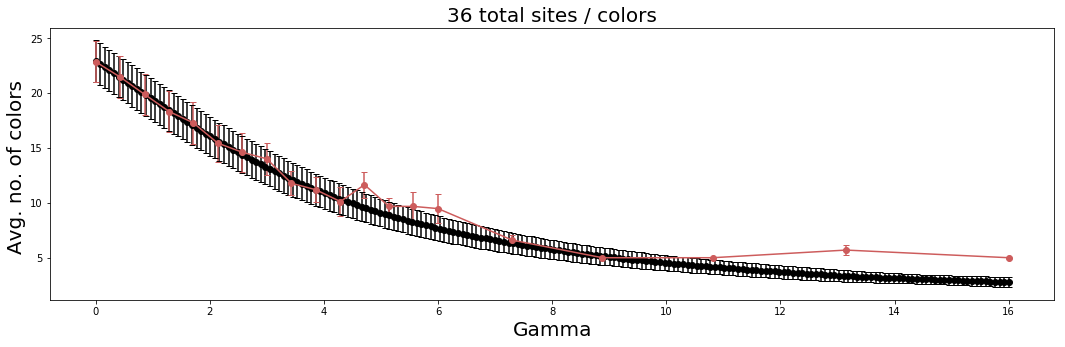

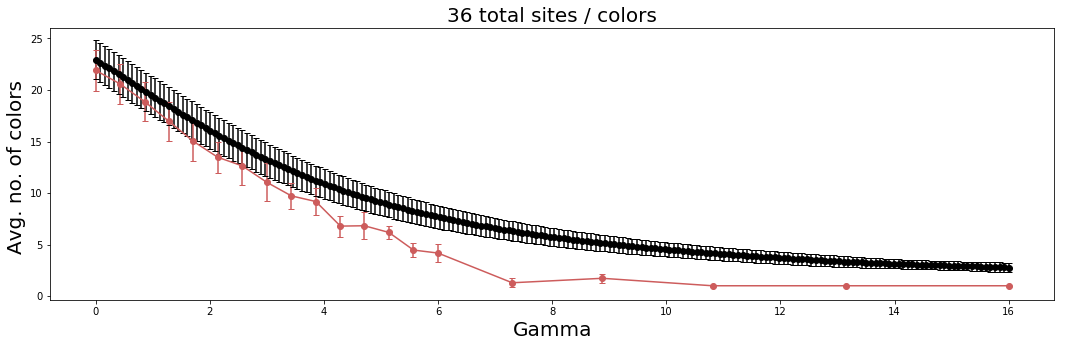

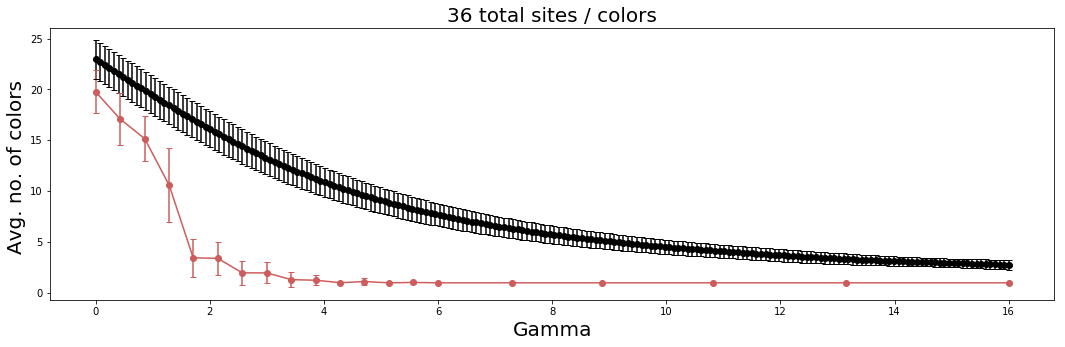

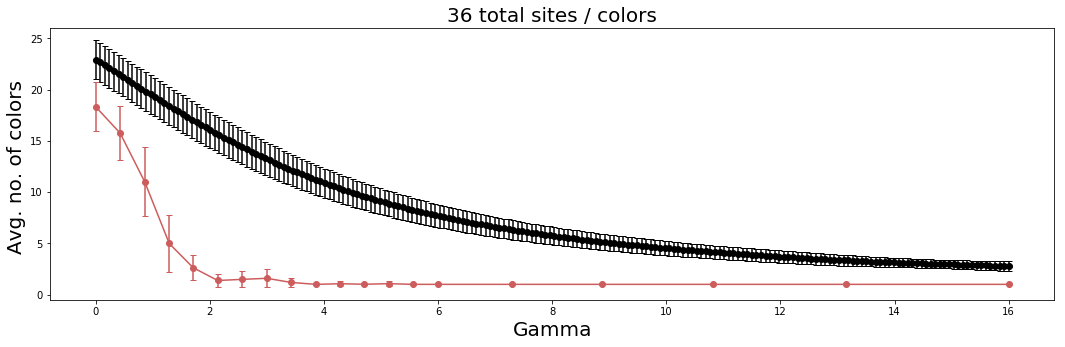

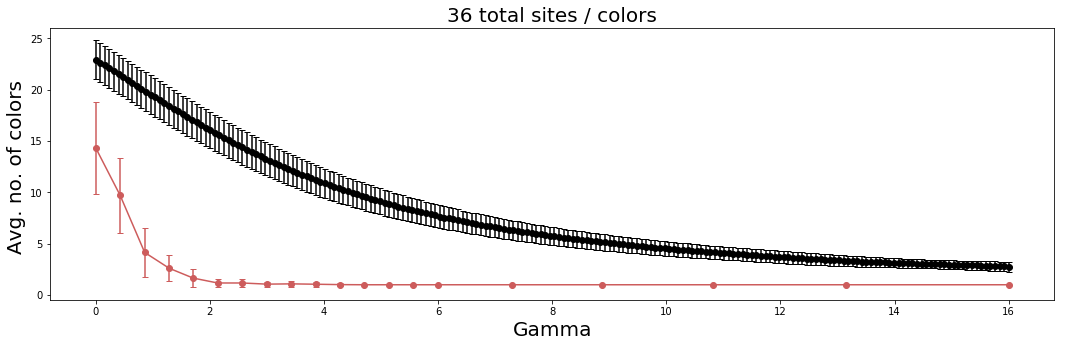

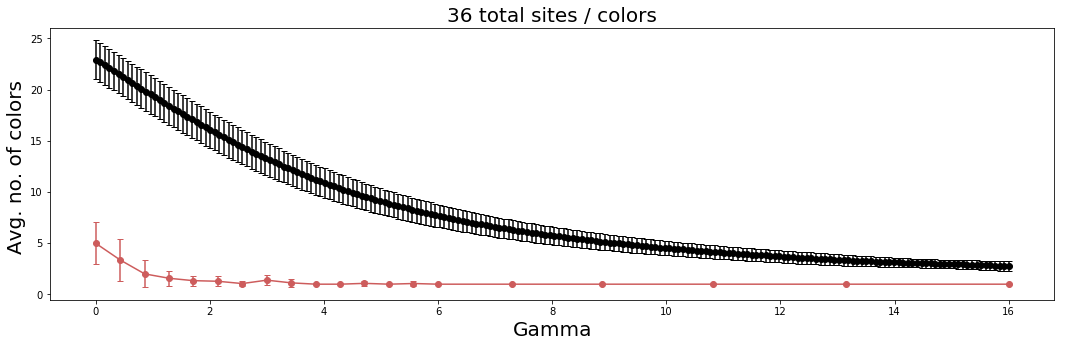

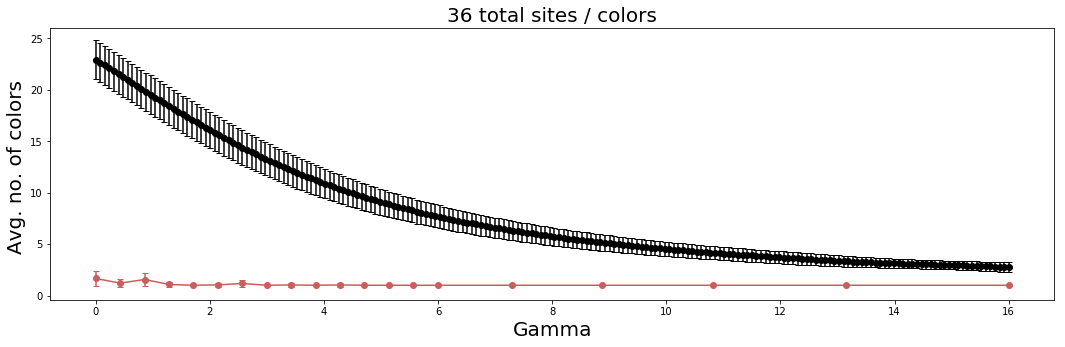

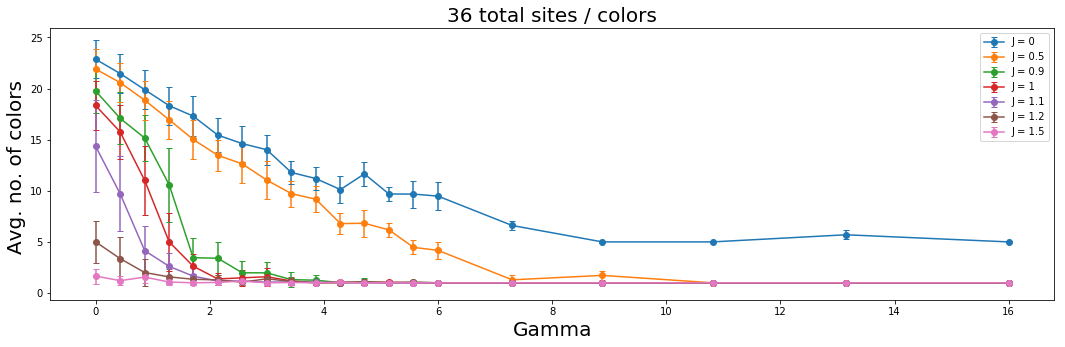

In [39]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
N = 6

nJ = 7
params, avg_c, std_c = [], [], []
Js = [0,0.5,0.9,1,1.1,1.2,1.5]
for J in Js:
    print("J:",J,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, J=J, gammas=gammas, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Js, "Gamma", "J")

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
N = 7

nJ = 7
params, avg_c, std_c = [], [], []
Js = [0,0.5,0.9,1,1.1,1.2,1.5]
for J in Js:
    print("J:",J,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, J=J, gammas=gammas, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, Js, "Gamma", "J")

J: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[47  8 19 30  2 10  5]
 [23 19 42 40 27 38 40]
 [44 27 21 33 13  4 23]
 [19 37  3 43 43 19 31]
 [22  7 10 42  9 33 46]
 [14 27 31 25  1 12 43]
 [28 45 49 31 40  1 46]]
equi

201 num. cols: 25.388059701492537 avg. sites per col: 1.9426016039728933
301 num. cols: 25.85049833887043 avg. sites per col: 1.9078922089890546
401 num. cols: 25.860349127182044 avg. sites per col: 1.90620819270722
501 num. cols: 25.75249500998004 avg. sites per col: 1.9138547365586687
601 num. cols: 25.445923460898502 avg. sites per col: 1.9387059246647844
701 num. cols: 25.282453637660485 avg. sites per col: 1.9509719426725822
801 num. cols: 25.151061173533083 avg. sites per col: 1.9624145976087326
901 num. cols: 25.299667036625973 avg. sites per col: 1.9510963570807973
1001 num. cols: 25.343656343656345 avg. sites per col: 1.9486832253320125
Final configuration:
[[20 28 45 38 42  4  4]
 [45  2 30 46 27  2  3]
 [39 24 42 30 24  3 16]
 [40 39  2 17 10 10  2]
 [24 38 46 10 10 38 24]
 [30 10  8 20 27 35 44]
 [39 39 38 17 45 17 30]]
Final averages: 25.324378109452738 1.9504463435064787
Final stds: 2.2611256687475514 0.17536258917715436
---------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 17.0 avg. sites per col: 2.8823529411764706
101 num. cols: 17.693069306930692 avg. sites per col: 2.773634697061039
201 num. cols: 17.81592039800995 avg. sites per col: 2.7545974333697862
301 num. cols: 17.538205980066444 avg. sites per col: 2.8045555635554877
401 num. cols: 18.423940149625935 avg. sites per col: 2.68775261396186
501 num. cols: 18.481037924151696 avg. sites per col: 2.678451494486933
601 num. cols: 18.500831946755408 avg. sites per col: 2.6749499491051414
701 num. cols: 18.01854493580599 avg. sites per col: 2.757167376857198
801 num. cols: 18.16729088639201 avg. sites per col: 2.735493130794931
901 num. cols: 18.294117647058822 avg. sites per col: 2.714062845551313
1001 num. cols: 18.37962037962038 avg. sites per col: 2.6990046601172866
Final configuration:
[[45 45 11 45 31 47  9]
 [28 28 10 37  4 27 15]
 [31 10 18 31  7 35 15]
 [47 